# Исследование объявлений о продаже квартир

**Описание проекта**

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Обзор и предобработка данных

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('yandex_realty_project_data.csv', sep='\t')

In [5]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Рассмотрев самую общую информацию о данных, можно предположить, что в сервисе, где размещались объявления о продаже, некоторые поля были обязательны к заполнению. Это общая площадь `total_area` и количество комнат `rooms`. Количество изображений `total_images`, цена продажи `last_price` и дата публикации `first_day_exposition`подгружались автоматически. 

В колонках с булевым типом данных - `studio` и `open_plan` - пропусков нет по той причине, что, вероятно, по умолчанию там стоит False. А в случае если квартира действительно является студией или имеет свободную планировку, продавец может это пометить как True. 

**Пропущенные значения** можно наблюдать в большинстве колонок: 

* `ceiling_height`
* `floors_total`
* `living_area`
* `is_apartment`
* `kitchen_area`
* `balcony`
* `locality_name`
* `airports_nearest`
* `cityCenters_nearest`
* `parks_around3000`
* `parks_nearest`
* `ponds_around3000`
* `ponds_nearest`
* `days_exposition`

Некоторые пропуски 

In [7]:
df.duplicated().sum()

0

Дубликатов нет!

Также вынесем в переменные количество строк и пропущенных значений в базе данных, чтобы по итогам предобработки подвести итог работы с ними.

In [8]:
# правка: добавляю переменную с общим количеством строк до предобработки

entries_original = len(df)
entries_original

23699

In [9]:
# правка: добавляю переменную с суммой всех пропусков до предобработки

nas_original = df.isnull().sum().sum()
nas_original

101441

### **`total_images`**

Количество изображений, опубликованных в объявлении. Здесь нет пропущенных значений. 

In [10]:
df['total_images'].describe().round()

count    23699.0
mean        10.0
std          6.0
min          0.0
25%          6.0
50%          9.0
75%         14.0
max         50.0
Name: total_images, dtype: float64

In [11]:
print (
    '{} объявлений представлено без изображений квартир.'
        .format(df.query('total_images == 0')['total_images'].count())
    )

print (
    'Это {:.1%} от всех объявлений.'
    .format(df.query('total_images == 0')['total_images'].count()/df['total_images'].count())
)

1059 объявлений представлено без изображений квартир.
Это 4.5% от всех объявлений.


### **`last_price`**

Цена на момент снятия публикации. Здесь также нет пропущенных значений, поскольку стоимость недвижимости так или иначе заполняется в объявлении. 

Можно посмотреть, как распределились значения, чтобы проверить, нет ли квартир с ценой в 0 рублей или с ошибочно указанной стоимостью. 

In [12]:
df['last_price'].describe().round(1)

count        23699.0
mean       6541548.8
std       10887013.3
min          12190.0
25%        3400000.0
50%        4650000.0
75%        6800000.0
max      763000000.0
Name: last_price, dtype: float64

In [13]:
df['last_price'].min()

12190.0

In [14]:
df.query('last_price < 1000000').describe().round(1)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,225.0,225.0,225.0,225.0,88.0,225.0,182.0,225.0,178.0,83.0,1.0,1.0,1.0,1.0,1.0,0.0,180.0
mean,8.2,768189.9,41.8,1.7,2.6,4.1,25.6,2.7,7.2,0.8,36421.0,9176.0,1.0,805.0,0.0,NaN,155.9
std,4.9,162790.4,11.9,0.7,0.3,2.1,8.9,2.2,3.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN,176.7
min,0.0,12190.0,18.0,0.0,2.5,1.0,12.5,1.0,3.0,0.0,36421.0,9176.0,1.0,805.0,0.0,NaN,3.0
25%,5.0,650000.0,32.0,1.0,2.5,2.0,17.5,1.0,6.0,0.0,36421.0,9176.0,1.0,805.0,0.0,NaN,45.0
50%,7.0,790000.0,41.0,2.0,2.5,5.0,26.0,2.0,6.5,1.0,36421.0,9176.0,1.0,805.0,0.0,NaN,82.0
75%,11.0,900000.0,47.2,2.0,2.6,5.0,31.0,4.0,8.0,1.0,36421.0,9176.0,1.0,805.0,0.0,NaN,201.8
max,20.0,999999.0,109.0,4.0,5.0,25.0,57.4,25.0,40.5,2.0,36421.0,9176.0,1.0,805.0,0.0,NaN,924.0


In [15]:
df.query('last_price < 500000').round(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.0,42.0,2017-07-31T00:00:00,2,NaN,1.0,23.0,1,NaN,...,5.8,NaN,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
6859,6,490000.0,40.0,2017-12-11T00:00:00,1,NaN,5.0,NaN,3,NaN,...,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.0
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.8,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000.0,43.4,2018-08-31T00:00:00,2,NaN,5.0,30.3,3,NaN,...,5.5,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
10782,3,490000.0,29.1,2016-05-05T00:00:00,1,2.5,5.0,17.0,5,NaN,...,5.5,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,719.0
14911,5,430000.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,NaN,...,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16032,8,480000.0,32.0,2019-01-06T00:00:00,1,NaN,2.0,16.0,1,NaN,...,NaN,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
16219,14,450000.0,38.5,2018-07-11T00:00:00,2,2.6,2.0,NaN,1,NaN,...,NaN,NaN,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16274,18,440000.0,40.0,2018-07-10T00:00:00,1,NaN,5.0,NaN,1,NaN,...,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17456,7,430000.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,NaN,...,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из срезов данных о квартирах со стоимость менее 500.000 рублей выбивается квартира с минимальной стоимостью - 12.190. Здесь явно опечатка: квартира находится в Санкт-Петербурге, а не в пригороде, у нее большая площадь (более 200 м2) и она расположена на 25 этаже - явно постройка относительно недавняя. 

Стоимость этой квартиры следует перезаписать: продавец явно недописал нули и перепутал тысячи рублей с миллионами. 

In [16]:
df.loc[8793, 'last_price']  = df.loc[8793, 'last_price']*1000

In [17]:
df.loc[8793, 'last_price']

12190000.0

### **`total_area`**

Общая площадь помещения. Здесь тоже нет пропущенных значений, вероятно, так как эта информация обязательна к заполнению. 

In [18]:
df['total_area'].describe().round()

count    23699.0
mean        60.0
std         36.0
min         12.0
25%         40.0
50%         52.0
75%         70.0
max        900.0
Name: total_area, dtype: float64

Здесь наблюдается довольно большой разброс значений площади помещений. Для того, чтобы представить, что из себя представляют квартиры с большой площадью, можно посмотреть, как квартиры 100м2 и более распределяются по цене и расстоянию до центра города. 

Количество квартир площадью более 100 м2: 1836
Доля квартир площадью более 100 м2 от всех представленных квартир: 7.75%


<AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>

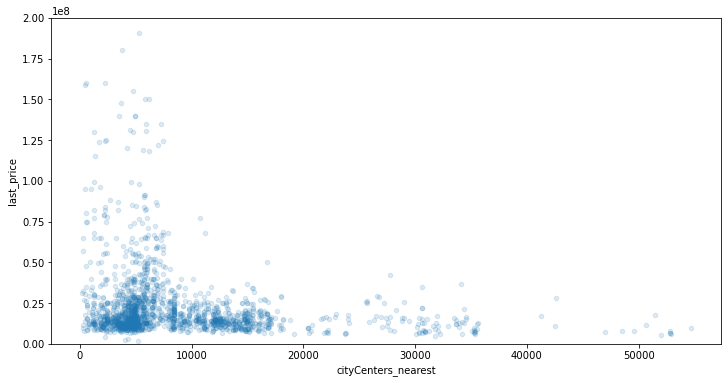

In [19]:
print ('Количество квартир площадью более 100 м2:', df.query('total_area > 100')['last_price'].count())
print ('Доля квартир площадью более 100 м2 от всех представленных квартир: {:.2%}'
       .format(df.query('total_area > 100')['last_price'].count()/len(df['last_price'])))
(
df.query('total_area > 100')
    .sort_values('last_price')
    .plot(x='cityCenters_nearest', y='last_price', kind='scatter', 
          #xlabel='Расстояние до центра, м', ylabel='Цена продажи', 
          alpha=0.15, ylim=(0, 200000000), figsize=(12,6))
)

Большинство больших квартир находятся рядом с центром (группа до 7 км), и именно они стоят дороже всего. Также можно заметить группу на окраине города (10-17 км от центра), цена большинства из которых не превышает 30 млн. рублей. Отдельные большие квартиры находятся в пригородах (от 20 км от центра города) - их цены держатся в районе 10-20 млн. рублей. 

Такое рапределение выглядит вполне правдоподобным и очевидным: самые дорогие большие квартиры в центре, большие квартиры подешевле - дальше от центра. 

 Далее имеет смысл выделить группы квартир в зависимости отих площади - это поможет в будущем при заполнении пропусков в других колонках. 

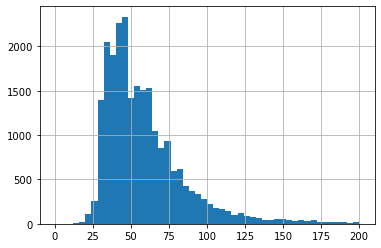

In [20]:
df['total_area'].hist(bins=50, range=(0,200))
plt.show()

Большинство квартир находится в промежутке от 30м2 до 70м2. 

Можно ввесли новую колонку `total_area_group`, которая каждой квартире назначит категорию в зависимости от ее `total_area`:
* менее 30м2
* 30-50м2
* 51-70м2
* 71-100м2
* 101-150м2
* 151-200м2
* более 201м2

Для этого нужно написать функцию для одной строки и применить ее ко всей базе данных. 

In [21]:
def total_area_group(row):
    total_area = row['total_area']
    
    if total_area < 30:
        return 'менее 30м2'
    elif 30 <= total_area <= 50:
        return '30-50м2'
    elif 50 < total_area <= 70:
        return '50-70м2'
    elif 70 < total_area <= 100:
        return '70-100м2'
    elif 100 < total_area <= 150:
        return '100-150м2'
    elif 150 < total_area <= 200:
        return '150-200м2'
    elif total_area > 200:
        return 'более 200м2'
    
    else:
        return 'ошибка'

In [22]:
df['total_area_group'] = df.apply(total_area_group, axis=1)

In [23]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,100-150м2
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,30-50м2
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,50-70м2
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,150-200м2
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,70-100м2


In [24]:
df['total_area_group'].value_counts()

30-50м2        10521
50-70м2         6747
70-100м2        3902
100-150м2       1272
менее 30м2       693
150-200м2        337
более 200м2      227
Name: total_area_group, dtype: int64

Ошибок нет, все работает!

### **`first_day_exposition`**


Дата публикации объявления. Пропущенных значений нет, потому что заполнялась автоматически. 

In [25]:
df['first_day_exposition'].describe()

count                   23699
unique                   1491
top       2018-02-01T00:00:00
freq                      368
Name: first_day_exposition, dtype: object

In [26]:
df['first_day_exposition'].max()

'2019-05-03T00:00:00'

Необходимо привести этот столбец к формату даты и времени.

In [27]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [28]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,100-150м2
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,30-50м2
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,50-70м2
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,150-200м2
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,70-100м2


Колонка приведена к формату даты и времени. Можно заметить, что время, везде указанное как 00:00:00 в колонке теперь не отображается - видна только дата. Это очень удобно.  

### **`rooms`**

Количество комнат в квартире. Здесь тоже нет пропусков. 

In [29]:
df['rooms'].describe().round(1)

count    23699.0
mean         2.1
std          1.1
min          0.0
25%          1.0
50%          2.0
75%          3.0
max         19.0
Name: rooms, dtype: float64

19 комнат - это немало. Можно посмотреть на квартиры, в которых 10 и более комнат. 

In [30]:
df['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

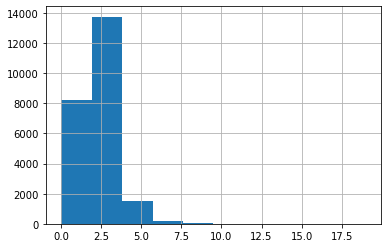

In [31]:
df['rooms'].hist(bins=10)
plt.show()

In [32]:
df.query('rooms == 0').pivot_table(index=['total_area_group', 'studio'], values='total_area', aggfunc=['count', 'median']).round(1)

count     median
                        total_area total_area
total_area_group studio                      
30-50м2          False          10       33.2
                 True           21       32.0
50-70м2          True            1       58.4
70-100м2         True            3       73.6
более 200м2      False           1      371.0
менее 30м2       False          48       25.7
                 True          113       25.0

Среди квартир с равным нулю количеством комнат большинство - маленькие (до 30м2) и студии 30-100 м2. Явно выбивается квартира площадью 371м2. Ей нужно установить количество комнат по медиане для группы квартир подобной площади. 

In [33]:
df.query('total_area_group == "более 200м2" and rooms==0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
19392,5,71000000.0,371.0,2018-07-26,0,3.57,7.0,NaN,6,NaN,...,NaN,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,90.0,более 200м2


In [34]:
df.query('total_area_group == "более 200м2"')['rooms'].median()

5.0

In [35]:
df.loc[19392, 'rooms'] = 5

Теперь с `rooms` все в порядке!

### **`floors_total`**

Общее количество этажей в здании. В этой колонке есть пропущенные значения. 

In [36]:
df['floors_total'].describe().round(1)

count    23613.0
mean        10.7
std          6.6
min          1.0
25%          5.0
50%          9.0
75%         16.0
max         60.0
Name: floors_total, dtype: float64

In [37]:
len(df[df['floors_total'].isna()])

86

В колонке `floors_total` имеется 86 пропущенных значений. Можно посмотреть, к каким этажам `floor` относятся эти строки. Может быть, они все на первом этаже, и тогда можно будет предположить, что все дома одноэтажные. Тогда можно запросто заполнить пропуски. 

In [38]:
df[df['floors_total'].isna()].describe().round(1)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,86.0,86.0,86.0,86.0,9.0,0.0,53.0,86.0,39.0,47.0,76.0,76.0,76.0,34.0,76.0,49.0,77.0
mean,5.5,6814281.8,62.5,1.9,2.8,NaN,32.4,10.0,13.7,0.1,30141.2,15666.7,0.6,549.9,0.8,475.7,181.9
std,4.0,5551091.6,37.2,1.1,0.1,NaN,19.0,6.2,5.8,0.4,13720.7,6999.3,0.8,529.8,0.7,243.7,232.2
min,0.0,1640000.0,23.2,0.0,2.6,NaN,10.0,1.0,3.5,0.0,7050.0,3148.0,0.0,24.0,0.0,130.0,3.0
25%,3.0,3480000.0,35.8,1.0,2.7,NaN,17.5,5.0,10.7,0.0,21570.8,11303.8,0.0,251.0,0.0,350.0,49.0
50%,5.0,5192500.0,56.0,2.0,2.8,NaN,31.0,8.0,12.2,0.0,25892.0,14637.0,0.0,400.0,1.0,374.0,111.0
75%,8.8,7523265.0,76.7,3.0,2.8,NaN,45.4,13.8,15.2,0.0,40679.0,17369.0,1.0,655.2,1.0,652.0,183.0
max,19.0,40348248.0,284.0,6.0,3.0,NaN,104.8,24.0,40.0,2.0,61908.0,34085.0,3.0,2276.0,3.0,1158.0,1257.0


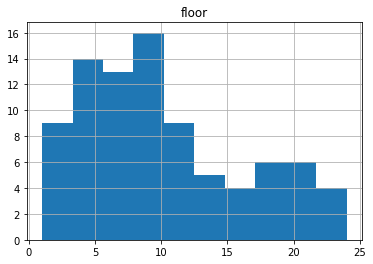

In [39]:
df[df['floors_total'].isna()].sort_values(by='floor').hist('floor', bins=10)
plt.show()

Судя по гистограмме, можно заметить, что большинство квартир с пропущенным значением в `floors_total` находятся на 8-10 этажах. Также есть пик (поменьше) на 4-6 этажах. Соответственно, предположение об одноэтажных постройках было неверным - данные об этажности дома просто не указали. Скорее всего это не заполнили сами продавцы недвижимости, так как эта информация не была обязательной к заполнению. 
Можно предположить, что это было указано в текстовом блоке объявления и потенциальные покупатели все равно эту информацию в большинстве случаев получили. 

Можно попробовать заполнить эти пропуски медианным значением `floors_total` для квартир, расположенных на том же этаже. Это не повлияет на данные, и точно не будет конфликта между этажом квартиры и этажностью дома. 

In [40]:
df['floors_total'] = df.groupby(['floor'])['floors_total']\
    .transform(lambda x: x.fillna(x.median()))

In [41]:
len(df[df['floors_total'].isna()])

0

Пропуски заполнены!

### **`locality_name`**

Название населенного пункта. Здесь имеются пропуски. 

In [42]:
df['locality_name'].describe()

count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

In [43]:
df['locality_name'].value_counts().head()

Санкт-Петербург    15721
посёлок Мурино       522
посёлок Шушары       440
Всеволожск           398
Пушкин               369
Name: locality_name, dtype: int64

In [44]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [45]:
len(df[df['locality_name'].isna()])

49

Если посмотреть на карту Санкт-Петербурга, можно обнаружить, что минимальное расстояние до границы Санкт-Петербурга и Ленинградской области - около 10км от центра. В этом случае, мы можем заполнить те пропущенные значения `locality_name`, в которых `cityCenters_nearest` меньше или равно 10000, заменив их на Санкт-Петербург. 

In [46]:
df[df['locality_name'].isna()].sort_values('cityCenters_nearest')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
16610,11,11940000.0,112.00,2015-11-19,3,3.00,5.0,64.00,2,NaN,...,0.0,NaN,21219.0,1322.0,1.0,740.0,3.0,365.0,319.0,100-150м2
22474,7,24000000.0,128.00,2015-07-24,4,2.75,6.0,68.40,6,False,...,0.0,NaN,23297.0,1780.0,3.0,277.0,3.0,561.0,436.0,100-150м2
4189,7,9200000.0,80.00,2015-12-10,3,4.00,4.0,52.30,3,False,...,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0,70-100м2
19045,6,4650000.0,48.00,2016-01-25,2,3.12,5.0,26.20,1,False,...,0.0,NaN,21654.0,3312.0,1.0,549.0,1.0,858.0,254.0,30-50м2
9821,13,8000000.0,94.50,2015-01-21,4,3.00,2.0,57.80,2,NaN,...,0.0,NaN,24953.0,3801.0,1.0,375.0,2.0,532.0,531.0,70-100м2
4151,17,17600000.0,89.50,2014-12-09,2,3.00,8.0,39.62,7,NaN,...,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0,70-100м2
8568,10,16000000.0,155.00,2016-05-09,3,NaN,6.0,94.00,3,NaN,...,0.0,NaN,24233.0,4065.0,1.0,547.0,0.0,NaN,248.0,150-200м2
11248,12,6300000.0,63.10,2015-01-16,4,NaN,8.0,44.00,7,NaN,...,0.0,NaN,25221.0,4069.0,0.0,NaN,2.0,653.0,551.0,50-70м2
1097,3,8600000.0,81.70,2016-04-15,3,3.55,5.0,50.80,2,NaN,...,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0,70-100м2
20057,13,11500000.0,102.00,2015-10-14,2,NaN,5.0,70.00,2,NaN,...,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,325.0,100-150м2


In [47]:
# функция для одной строки, которая будет обращаться к locality_name,
# если там будет пропущенное значение,
# функция будет смотреть на значение cityCenters_nearest 
# далее, если занчение cityCenters_nearest меньше или равно 10км,
# locality_name заменяется на "Санкт-Петербург"
# если эти оба условия не выполняются, locality_name остается NaN

def locality_name_fillna (row):
    locality_name = row['locality_name']
    cityCenters_nearest = row['cityCenters_nearest']
    
    if pd.isnull(locality_name)==True and cityCenters_nearest<=10000:
        name='Санкт-Петербург'
        return name
    else:
        return locality_name

In [48]:
# применяем функцию ко всему датафрейму

df['locality_name'] = df.apply(locality_name_fillna, axis=1)

In [49]:
df[df['locality_name'].isna()].sort_values('cityCenters_nearest').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group
17764,9,8400000.0,94.0,2016-01-24,3,NaN,23.0,52.0,5,NaN,...,0.0,NaN,36865.0,10976.0,0.0,NaN,1.0,856.0,305.0,70-100м2
7600,8,6800000.0,70.0,2016-01-31,3,NaN,11.0,42.0,9,NaN,...,1.0,NaN,37123.0,12332.0,0.0,NaN,0.0,NaN,209.0,50-70м2
12879,12,4400000.0,39.2,2016-04-26,1,NaN,12.0,20.0,12,False,...,0.0,NaN,37123.0,12332.0,0.0,NaN,0.0,NaN,179.0,30-50м2
5707,7,3700000.0,30.0,2016-04-29,1,NaN,24.0,20.0,23,NaN,...,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0,30-50м2
2603,20,3351765.0,42.7,2015-09-20,1,NaN,24.0,15.6,3,NaN,...,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0,30-50м2


In [50]:
df['locality_name'].value_counts().head()

Санкт-Петербург    15746
посёлок Мурино       522
посёлок Шушары       440
Всеволожск           398
Пушкин               369
Name: locality_name, dtype: int64

In [51]:
len(df[df['locality_name'].isna()])

24

Пропущенных значений осталось 24 - не очень много. Мы можем спокойно от них избавиться, ведь перезаписать их мы не можем. Можно, конечно, вывести их в отдельную категорию, например, "Другое", но это ничего не изменит. Поэтому стоит удалить.

In [52]:
df = df.dropna(subset=['locality_name']) 

In [53]:
len(df[df['locality_name'].isna()])

0

Пропусков в этой колонке больше нет!

Для дальнейшей работы будет удобно сгруппировать населенные пункты - уж очень их много. 

Категории могут быть следующими:
* Санкт-Петербург
* город в ЛО
* поселок/пгт/коттеджный
* деревня/село/садовое товарищество

Для группировки достаточно написать функцию для строки, а потом пройтись ей по всей базе. 

In [54]:
def locality_group(row):
    locality_name = row['locality_name']
    
    if 'Санкт-Петербург' in locality_name:
        return 'Санкт-Петербург'
    
    elif ('поселок' in locality_name) or ('посёлок' in locality_name):
        return 'поселок/пгт/коттеджный'
    
    elif ('деревня' in locality_name) or ('село' in locality_name) or ('товарищество' in locality_name):
        return 'деревня/село/садовое товарищество'
    
    else:
        return 'город в ЛО'

In [55]:
df['locality_group'] = df.apply(locality_group, axis=1)

In [56]:
def freq(x): return '{:.1%} '.format(x.count()/len(df))

In [57]:
df['locality_group'].count()

23675

In [58]:
df.pivot_table(index='locality_group', values='rooms', aggfunc=['count', freq])

,count,freq
,rooms,rooms
locality_group,,
Санкт-Петербург,15746,66.5%
город в ЛО,4287,18.1%
деревня/село/садовое товарищество,982,4.1%
поселок/пгт/коттеджный,2660,11.2%


И действительно: бóльшая часть квартир из базы расположены в Санкт-Петербурге. Далее следуют города Ленинградской области, и за ними - поселки и деревни. 

### **`ceiling_height`**

Высота потолка в помещении в метрах. Здесь уже присуствуют пропуски - эту информацию указывают не везде. Пропуски нужно изучить. 

In [59]:
df['ceiling_height'].describe().round(1)

count    14499.0
mean         2.8
std          1.3
min          1.0
25%          2.5
50%          2.6
75%          2.8
max        100.0
Name: ceiling_height, dtype: float64

Смущает максимальное значение - потолок не может быть 100 метров. Можно посмотреть на квартиры с потолком от 5 метров и выше. 

In [60]:
df.query('ceiling_height >= 5').sort_values('ceiling_height', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
22869,0,15000000.0,25.0,2018-07-25,1,100.0,5.0,14.0,5,True,...,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,менее 30м2,Санкт-Петербург
22336,19,9999000.0,92.4,2019-04-05,2,32.0,6.0,55.5,5,False,...,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN,70-100м2,Санкт-Петербург
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70-100м2,город в ЛО
21377,19,4900000.0,42.0,2017-04-18,1,27.5,24.0,37.7,19,False,...,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0,30-50м2,Санкт-Петербург
22938,14,4000000.0,98.0,2018-03-15,4,27.0,2.0,73.0,2,True,...,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0,70-100м2,деревня/село/садовое товарищество
21824,20,2450000.0,44.0,2019-02-12,2,27.0,2.0,38.0,2,False,...,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-50м2,поселок/пгт/коттеджный
20478,11,8000000.0,45.0,2017-07-18,1,27.0,4.0,22.0,2,NaN,...,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0,30-50м2,Санкт-Петербург
4876,7,3000000.0,25.0,2017-09-27,0,27.0,25.0,17.0,17,NaN,...,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0,менее 30м2,поселок/пгт/коттеджный
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,50-70м2,деревня/село/садовое товарищество
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,NaN,...,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,70-100м2,Санкт-Петербург


Сразу бросаются в глаза квартиры с полотками более 20 метров: можно предположить, что здесь имеет место опечатка, и потолки высотой 2.5 метра, а не 25. Следует взять все квартиры, где потолки выше 20 метров, и умножить их на 0.1.

Что касается квартир с полотком в 10 и 14 метров, расположенных в 15-ти и 5-ти этажных зданиях - тоже возникают сомнения. Эти значения можно заменить на NaN, чтобы они не оказывали влияние на данные. 

In [61]:
df.loc[df['ceiling_height']>=20, ['ceiling_height']] /= 10

In [62]:
df.loc[df['ceiling_height']>=10, ['ceiling_height']]=np.nan

Также смутило минимальное значение высоты полотков - 1 метр. Это тоже необходимо изучить. 

In [63]:
df.query('ceiling_height < 2').sort_values('ceiling_height', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37.0,17.4,5,NaN,...,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0,30-50м2,Санкт-Петербург
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2.0,27.5,1,NaN,...,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0,30-50м2,поселок/пгт/коттеджный
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12.0,32.4,7,NaN,...,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,50-70м2,Санкт-Петербург


Эти три значения тоже лучше приписать к пропущенным - уж подозрительно низкие полотки. 

In [64]:
df.loc[df['ceiling_height']<2, ['ceiling_height']]=np.nan

In [65]:
len(df[df['ceiling_height'].isna()])

9182

In [66]:
(
print('Пропущенные значения в переменной ceiling_height составляют {:.1%} от всех значений.'
      .format(len(df[df['ceiling_height'].isna()])/len(df['ceiling_height'])))
     )

Пропущенные значения в переменной ceiling_height составляют 38.8% от всех значений.


In [67]:
df['ceiling_height'].describe().round(1)

count    14493.0
mean         2.7
std          0.3
min          2.0
25%          2.5
50%          2.6
75%          2.8
max          8.3
Name: ceiling_height, dtype: float64

В `ceiling_height` мы оставляем пропуски, так как не можем утверждать, что эти пропуски случайны и, соответственно, их заполнение не повлияет на данные.   

### **`living_area`**

Жилая прощадь в м2 - то есть площадь гостиных и спален. Это составная часть `total_area` (общая площадь), в которую помимо это дилой площади уже входят и площадь кухни, коридора, ванной и всего остального.

`living_area` - явно не обязательная информация при выставлении объявления, поэтому, вероятно, многие продавцы решили ей пренебречь. 


In [68]:
df['living_area'].describe().round(1)

count    21775.0
mean        34.5
std         22.0
min          2.0
25%         18.6
50%         30.0
75%         42.3
max        409.7
Name: living_area, dtype: float64

In [69]:
df.query('living_area<10').sort_values('living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
21758,0,2330000.0,23.00,2018-01-01,0,NaN,24.0,2.0,22,NaN,...,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0,менее 30м2,поселок/пгт/коттеджный
13915,20,6350000.0,52.00,2018-02-06,2,3.00,6.0,2.0,2,NaN,...,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0,50-70м2,Санкт-Петербург
23574,14,64990000.0,139.00,2015-11-24,3,3.00,8.0,3.0,8,NaN,...,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0,100-150м2,Санкт-Петербург
3242,7,4440000.0,41.00,2017-07-02,1,NaN,17.0,3.0,17,NaN,...,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0,30-50м2,Санкт-Петербург
17582,11,2680000.0,22.00,2018-08-11,0,NaN,25.0,5.0,8,NaN,...,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0,менее 30м2,Санкт-Петербург
21943,15,6100000.0,77.60,2019-02-28,4,2.50,9.0,5.4,1,NaN,...,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0,70-100м2,Санкт-Петербург
16431,13,3799000.0,31.00,2018-04-12,1,2.60,5.0,6.0,1,NaN,...,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0,30-50м2,Санкт-Петербург
19251,19,4050000.0,33.00,2018-10-15,1,2.50,22.0,6.5,21,NaN,...,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0,30-50м2,Санкт-Петербург
20994,7,8900000.0,50.60,2018-10-22,2,2.50,7.0,8.0,3,NaN,...,Санкт-Петербург,12771.0,8301.0,1.0,173.0,3.0,126.0,NaN,50-70м2,Санкт-Петербург
23208,12,4800000.0,37.00,2016-02-24,1,NaN,14.0,8.0,11,NaN,...,Санкт-Петербург,27838.0,12387.0,2.0,358.0,1.0,950.0,139.0,30-50м2,Санкт-Петербург


Вызывают недоверие квартиры, в которых жилая площадь очень маленькая, хотя общая площадь на уровне или выше медианной. Для того, чтобы эти значения не влияли на данные, лучше из заменить на NaN. Эту замену можно произвести при условии, если доля жилой площади составляет менее трети доли общей площади. 
К примеру, 9м2 жилой площади в квартире 18м2 - это кажется нормальным. А вот 3м2 жилой площади в квартире общей площадь 41м2 стоит заменить на пропуск. 

In [70]:
len(df[df['living_area'].isna()])

1900

In [71]:
def living_area_nan (row):
    living_area = row['living_area']
    total_area = row['total_area']
    
    if living_area<10 and (living_area/total_area)<0.33:
        area_nan=np.nan
        return area_nan
    else:
        return living_area

In [72]:
df['living_area'] = df.apply(living_area_nan, axis=1)

In [73]:
df.query('living_area < 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
114,5,4000000.0,21.4,2019-02-07,1,2.9,8.0,8.3,7,NaN,...,Санкт-Петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN,менее 30м2,Санкт-Петербург
4542,12,3300000.0,18.0,2018-11-07,1,3.5,5.0,9.0,2,NaN,...,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0,менее 30м2,Санкт-Петербург
7312,8,3400000.0,27.0,2018-02-21,2,2.5,15.0,9.0,4,NaN,...,Санкт-Петербург,50246.0,16444.0,1.0,617.0,0.0,NaN,NaN,менее 30м2,Санкт-Петербург


In [74]:
len(df[df['living_area'].isna()])

1922

In [75]:
df['living_area'].describe().round(1)

count    21753.0
mean        34.5
std         22.0
min          8.3
25%         18.6
50%         30.0
75%         42.3
max        409.7
Name: living_area, dtype: float64

Теперь смысл сравнить `living_area` с `total_area`: первая не может быть больше второй. Это стоит проверить на предмет ошибок. 

In [76]:
df.query ('living_area >= total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
9861,10,2350000.0,25.0,2017-12-03,0,NaN,22.0,25.0,17,NaN,...,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,13.0,менее 30м2,поселок/пгт/коттеджный
12691,1,3700000.0,24.2,2017-11-10,0,NaN,19.0,24.2,13,NaN,...,Санкт-Петербург,17837.0,16840.0,0.0,NaN,2.0,210.0,74.0,менее 30м2,Санкт-Петербург


In [77]:
df.query ('living_area >= total_area')['studio']

9861     False
12691    False
Name: studio, dtype: bool

Нашлись две квартиры, у которых жилая площадь равна общей площади. Такого быть не может, так как в любом случае предполагается как минимум ванная комната, даже если коридора нет. В этих двух случаях можно перестраховаться и заменить `living_area` на NaN. 

In [78]:
df.loc[9861, 'living_area'] = np.nan
df.loc[12691, 'living_area'] = np.nan

In [79]:
len(df[df['living_area'].isna()])

1924

Теперь можно и поработать с пропущенными значениями. `living_area` можно заполнить медианой для группы квартир с подобной площадью (созданная колонка `floors_total_group`) и количеством комнат. 

In [80]:
df['living_area'] = df.groupby(['rooms', 'total_area_group'])['living_area']\
    .transform(lambda x: x.fillna(x.median()))

In [81]:
len(df[df['living_area'].isna()])

1

In [82]:
df[df['living_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
9826,1,43185328.0,494.1,2017-05-12,1,2.85,12.0,NaN,3,NaN,...,Санкт-Петербург,28529.0,6832.0,1.0,592.0,0.0,NaN,5.0,более 200м2,Санкт-Петербург


In [83]:
df[df['living_area'].isna()]['open_plan']

9826    False
Name: open_plan, dtype: bool

Большинство пропусков заполнились! Осталась одна очень большая однокомнатная квартира. С ней все в порядке по соотношению площадь-цена-расстояние до центра - точно не ошибка с площадью. 
Пропуск здесь мы заполним по медианному значению по площади, не обращая внимания на количество комнат. 

In [84]:
df['living_area'] = df.groupby(['total_area_group'])['living_area']\
    .transform(lambda x: x.fillna(x.median()))

In [85]:
len(df[df['living_area'].isna()])

0

Пропусков нет!

### **`floor`**

Этаж, на котором расположена квартира. Здесь пропусков нет, однако есть смысл проверить, какие есть значения этажей (нет ли нулевых, например) и сравнить `floor` с `floors_total`: первое не может превышать второе. 

In [86]:
df['floor'].value_counts()

2     3361
3     3069
1     2915
4     2803
5     2620
6     1305
7     1217
8     1083
9     1050
10     687
12     525
11     523
13     379
15     343
14     335
16     315
17     227
18     178
19     147
21     123
22     112
20     110
23      99
24      63
25      46
26      24
27      10
28       1
30       1
29       1
32       1
33       1
31       1
Name: floor, dtype: int64

Нулевого и нереалистично большого этажей нет!

In [87]:
df[df['floor'] > df['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group


И живущих на чердаках или крыше тоже нет! Можно переходить дальше. 

### **`is_apartment`**

Является ли квартира апартаментами - то есть нежилым помещением, в котором есть все условия для жизни. 
Данные в этой колонке типа object и заполнены только 2775 (из 23699) значений. 

In [88]:
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

Поскольку значения здесь True, False или NaN, имеет смысл сделать эту переменную булевой, а пропуски заменить на False: ведь если не указано, что это апартаменты, скорее всего помещение ими и не является. 

In [89]:
df[df['is_apartment'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,100-150м2,Санкт-Петербург
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,NaN,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,30-50м2,поселок/пгт/коттеджный
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,NaN,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,50-70м2,Санкт-Петербург
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,86.00,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,150-200м2,Санкт-Петербург
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,NaN,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,70-100м2,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.30,3,NaN,...,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,100-150м2,Санкт-Петербург
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.00,4,NaN,...,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,50-70м2,город в ЛО
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.70,1,NaN,...,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-70м2,деревня/село/садовое товарищество
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,39.62,12,NaN,...,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,70-100м2,Санкт-Петербург


In [90]:
df['is_apartment'] = df['is_apartment'].fillna(False)

In [91]:
df['is_apartment'].unique()

array([False,  True])

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23675 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23675 non-null  int64         
 1   last_price            23675 non-null  float64       
 2   total_area            23675 non-null  float64       
 3   first_day_exposition  23675 non-null  datetime64[ns]
 4   rooms                 23675 non-null  int64         
 5   ceiling_height        14493 non-null  float64       
 6   floors_total          23675 non-null  float64       
 7   living_area           23675 non-null  float64       
 8   floor                 23675 non-null  int64         
 9   is_apartment          23675 non-null  bool          
 10  studio                23675 non-null  bool          
 11  open_plan             23675 non-null  bool          
 12  kitchen_area          21403 non-null  float64       
 13  balcony         

Теперь пропусков нет, и колонка стала типа bool. Можно двигать дальше. 

### **`studio`**

Является ли квартира студией. Тип данных bool - колонка принимает значения True или False. 

In [93]:
df['studio'].unique()

array([False,  True])

In [94]:
df['studio'].value_counts()

False    23526
True       149
Name: studio, dtype: int64

150 студий на всю базу данных. Пропущенных значений нет. 

### **`open_plan`**

Имеет ли квартира открытую (свободную) планировку. Здесь булев тип данных, пропусков нет.

In [95]:
df['open_plan'].unique()

array([False,  True])

In [96]:
df['open_plan'].value_counts()

False    23608
True        67
Name: open_plan, dtype: int64

67 квартир со свободной планировкой. 

### **`kitchen_area`**

Площадь кухни. Здесь имеются пропуски - вероятно, это было необязательной информацией для заполнения. 

In [97]:
len(df[df['kitchen_area'].isna()])

2272

Здесь тоже можно сравнить площадь кухни и общую площадь `total_area`.

In [98]:
df.query ('kitchen_area >= total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group


Таких квартир нет! Значит можно заполнять пропуски, исходя из общей площади `total_area_group`.

In [99]:
df['kitchen_area'] = df.groupby(['total_area_group'])['kitchen_area']\
    .transform(lambda x: x.fillna(x.median()))

In [100]:
len(df[df['kitchen_area'].isna()])

0

Пропусков нет!

### **`balcony`**

Здесь указано число балконов, также имеются пропущенные значения. Тип данных - float. 

In [101]:
len(df[df['balcony'].isna()])

11513

In [102]:
df['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Пропущенных значений много, и здесь их можно заполнить. Разумным будет допустить, что если число балконов не указано, их и нет вовсе. Скорее всего, число балконов указывать было необязательно, поэтому, если их не было - число и не указали.

In [103]:
df['balcony'] = df['balcony'].fillna(0)

In [104]:
df['balcony'].value_counts()

0.0    15259
1.0     4190
2.0     3658
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

Немного странно, что 4 и 5 балконов встречаются в базе чаще, чем 3. Можно посмотреть на строки, в которых балконов 4 и больше. 

In [105]:
df.query('balcony >=4').pivot_table(index=['total_area_group', 'rooms'], values='total_area', aggfunc=['count', 'median'])

count     median
                       total_area total_area
total_area_group rooms                      
100-150м2        2              2    129.300
                 3             39    118.000
                 4             22    114.150
                 5              3    130.000
150-200м2        3              6    174.500
                 4              4    157.400
                 5              5    172.700
30-50м2          1             31     43.000
                 2             20     48.485
50-70м2          1              8     52.300
                 2             81     60.000
                 3             84     60.200
70-100м2         1              1     95.000
                 2             41     78.000
                 3            119     85.000
                 4             15     86.600
более 200м2      3              1    249.700
                 5              2    227.500
                 7              2    397.850
менее 30м2       1              1     25.000

В квартирах с 1 и 2 комнатами 4 и более балконов выглядят довольно странно. Эти балконы следует заменить на медиану по квартирам с подобной площадью и количеством комнат. 

Сначала мы оформим эти случаи как пропуски, а потом заполним их через _transform_.

In [106]:
df.loc[(df['balcony'] >= 4) & (df['rooms'] <= 2),['balcony']]=np.nan

In [107]:
len(df[df['balcony'].isna()])

185

In [108]:
df['balcony'] = df.groupby(['total_area_group'])['balcony']\
    .transform(lambda x: x.fillna(x.median()))

In [109]:
df[df['balcony'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group


Пропуски заполнились! А типом данных мы займемся на следующем этапе.

### **`cityCenters_nearest`**

Расстояние до центра Санкт-Петербурга в метрах. Тип данных - float, есть пропуски.

In [110]:
len(df[df['cityCenters_nearest'].isna()])

5511

In [111]:
df['cityCenters_nearest'].describe().round(1)

count    18164.0
mean     14186.2
std       8607.2
min        181.0
25%       9234.0
50%      13094.0
75%      16293.0
max      65968.0
Name: cityCenters_nearest, dtype: float64

Имеющиеся данные не выглядят подозрительно - видно, что большинство квартир находится в Петербурге или близайшей области, но есть квартиры в ЛО чуть подальше. Можно это визуализировать.

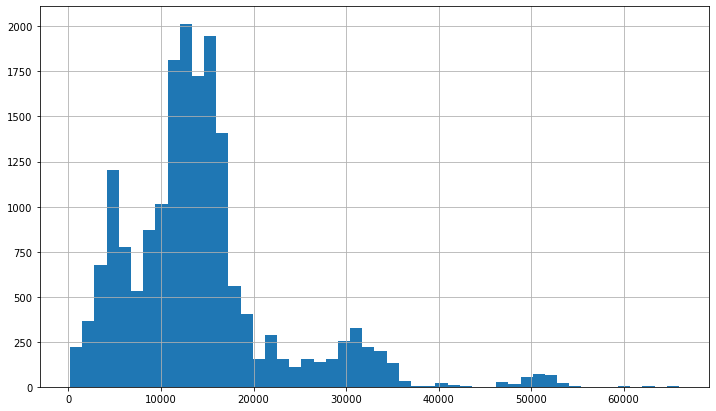

In [112]:
df['cityCenters_nearest'].hist(bins=50, figsize=(12, 7))
plt.show()

Стоит взглянуть, что это за населенные пункты от 45 км от центра.

In [113]:
df.query('cityCenters_nearest > 45000').pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='median')

,cityCenters_nearest
locality_name,
Зеленогорск,53381.0
Кронштадт,49575.0
Ломоносов,51772.0
Петергоф,48914.5
посёлок Молодёжное,65764.0
посёлок Репино,45226.0


По картам проверяются. Все в порядке.

In [114]:
(
print('Пропущенные значения в переменной cityCenters_nearest составляют {:.1%} от всех значений.'
      .format(len(df[df['cityCenters_nearest'].isna()])/len(df['cityCenters_nearest'])))
     )

Пропущенные значения в переменной cityCenters_nearest составляют 23.3% от всех значений.


In [115]:
#df['cityCenters_nearest'] = df.groupby(['locality_group','total_area_group','last_price'])['cityCenters_nearest']\
#    .transform(lambda x: x.fillna(x.median()))

Осталось довольно много пропусков - 5511 строк с пропущенными значениями в `cityCenters_nearest`, что составляет 23.3% от всех значений `cityCenters_nearest`.

К сожалению, мы не имеем возможности адекватно заполнить эти пропуски так, чтобы `cityCenters_nearest` не попал в зависимость от других признаков. Поэтому пропуски можно оставить, но помнить про них в дальнейшем. 

### **`airports_nearest`**

Расстояние до ближайшего аэропорта в метрах. Тип данных - float (потом исправим). Пропуски имеются.

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23675 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23675 non-null  int64         
 1   last_price            23675 non-null  float64       
 2   total_area            23675 non-null  float64       
 3   first_day_exposition  23675 non-null  datetime64[ns]
 4   rooms                 23675 non-null  int64         
 5   ceiling_height        14493 non-null  float64       
 6   floors_total          23675 non-null  float64       
 7   living_area           23675 non-null  float64       
 8   floor                 23675 non-null  int64         
 9   is_apartment          23675 non-null  bool          
 10  studio                23675 non-null  bool          
 11  open_plan             23675 non-null  bool          
 12  kitchen_area          23675 non-null  float64       
 13  balcony         

In [117]:
len(df[df['airports_nearest'].isna()])

5534

In [118]:
df['airports_nearest'].describe().round(1)

count    18141.0
mean     28795.4
std      12632.4
min          0.0
25%      18578.0
50%      26736.0
75%      37284.0
max      84869.0
Name: airports_nearest, dtype: float64

Есть 5534 пропуска. Мы сможем их заполнить через _transform()_ по медиане для `locality_group` и `cityCenters_nearest`. Но сначала мы изучим те случаи, когда расстояние до аэропорта очень маленькое или равно нулю: это может действительно быть населенный пункт рядом с аэропортом, а может быть и ошибка в данных. Далее стит изучить минимальное, среднее и максимальное расстояние по населенным пунктам (хотя бы по самым основным), чтобы проверить, не занесло ли туда какие-то ошибочные значения.

In [119]:
df.query('airports_nearest < 2000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group
21085,0,7000000.0,34.7,2018-09-23,1,2.7,9.0,19.8,3,False,...,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0,30-50м2,Санкт-Петербург


Только один случай. Его можно сделать NaN.

In [120]:
df.loc[df['airports_nearest']<2000, ['airports_nearest']] = np.nan

In [121]:
airport_localities = df.pivot_table(
    index='locality_name', values='airports_nearest', aggfunc=['min', 'mean', 'median', 'max', np.std])
airport_localities.columns = ['min', 'mean', 'median', 'max', 'std_dev']
airport_localities = airport_localities.sort_values('std_dev', ascending=False).round()

In [122]:
airport_localities

,min,mean,median,max,std_dev
locality_name,,,,,
Санкт-Петербург,6450.0,28040.0,26736.0,54784.0,11550.0
Петергоф,34626.0,40185.0,39231.0,46535.0,4078.0
посёлок Шушары,9294.0,16061.0,17427.0,26293.0,3814.0
Зеленогорск,70016.0,73300.0,72282.0,81607.0,3049.0
посёлок Парголово,44346.0,53995.0,53426.0,61748.0,2992.0
Красное Село,23892.0,26596.0,25716.0,38367.0,2762.0
Пушкин,12157.0,16448.0,15766.0,21055.0,2493.0
Сестрорецк,50031.0,56640.0,56692.0,61872.0,2118.0
посёлок Песочный,52504.0,54566.0,54832.0,56095.0,1819.0


Мы видим стандартное отклонение более 10 км в Санкт-Петербурге. Тут большое отклонение не удивляет - город немаленький, и какие-то дома находятся в городской зоне рядом с Пулково, в то время, как другие могут находиться в противоположной стороне города. 
Однако минимальное расстояние до аэропорта - 6.4 км, а максимальное - более 50. Судя по карте города, максимальное расстояние от города до Пулково подтверждается, если строить маршруты.

В таком случае, ничего не мешает попробовать заполнить пропуски.

In [123]:
df['airports_nearest'] = df.groupby(['locality_name', 'cityCenters_nearest'])['airports_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [124]:
len(df[df['airports_nearest'].isna()])

5520

In [125]:
df['airports_nearest'] = df.groupby(['locality_name'])['airports_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [126]:
len(df[df['airports_nearest'].isna()])

5386

Пропуски остались: пройдемся только медианой `locality_group`.

In [127]:
df['airports_nearest'] = df.groupby(['locality_group'])['airports_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [128]:
len(df[df['airports_nearest'].isna()])

982

Осталось 982 пропуска, которые в дальнейшим "протягиваются" по другим столбцам. Эти 982 строки можно просто удалить.

In [129]:
df = df.dropna(subset=['airports_nearest']) 

In [130]:
len(df[df['airports_nearest'].isna()])

0

Пропусков нет!

### **`parks_around3000`**
Количество парков в радиусе 3 км от квартиры. 

In [131]:
df['parks_around3000'].describe().round(1)

count    18165.0
mean         0.6
std          0.8
min          0.0
25%          0.0
50%          0.0
75%          1.0
max          3.0
Name: parks_around3000, dtype: float64

In [132]:
len(df[df['parks_around3000'].isna()])

4528

Пропуски можно заполнить медианой по `locality_name`, далее по `locality_group`. 

In [133]:
df['parks_around3000'] = df.groupby(['locality_name'])['parks_around3000']\
    .transform(lambda x: x.fillna(x.median()))

In [134]:
len(df[df['parks_around3000'].isna()])

4404

In [135]:
df['parks_around3000'] = df.groupby(['locality_group'])['parks_around3000']\
    .transform(lambda x: x.fillna(x.median()))

In [136]:
len(df[df['parks_around3000'].isna()])

0

Пропусков нет!

### `parks_nearest`
Расстояние до ближайшего парка в метрах. 

In [137]:
df['parks_nearest'].describe().round(1)

count    8079.0
mean      490.8
std       342.3
min         1.0
25%       288.0
50%       455.0
75%       612.0
max      3190.0
Name: parks_nearest, dtype: float64

In [138]:
len(df[df['parks_nearest'].isna()])

14614

In [139]:
df['parks_nearest'] = df.groupby(['locality_name', 'cityCenters_nearest', 'parks_around3000'])['parks_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [140]:
len(df[df['parks_nearest'].isna()])

14615

In [141]:
df['parks_nearest'] = df.groupby(['locality_group'])['parks_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [142]:
len(df[df['parks_nearest'].isna()])

0

Пропусков нет!

### `ponds_around3000`
Количество водоемов в радиусе 3 км от квартиры. 

In [143]:
df['ponds_around3000'].describe().round(1)

count    18165.0
mean         0.8
std          0.9
min          0.0
25%          0.0
50%          1.0
75%          1.0
max          3.0
Name: ponds_around3000, dtype: float64

In [144]:
len(df[df['ponds_around3000'].isna()])

4528

Пропуски можно заполнить медианой по `locality_name`, далее по `locality_group`, a оставшиеся - медианой по колонке. 

In [145]:
df['ponds_around3000'] = df.groupby(['locality_name'])['ponds_around3000']\
    .transform(lambda x: x.fillna(x.median()))

In [146]:
len(df[df['ponds_around3000'].isna()])

4404

In [147]:
df['ponds_around3000'] = df.groupby(['locality_group'])['ponds_around3000']\
    .transform(lambda x: x.fillna(x.median()))

In [148]:
len(df[df['ponds_around3000'].isna()])

0

Пропусков нет!

### `ponds_nearest`
Расстояние до ближайшего водоема в метрах. 

In [149]:
df['ponds_nearest'].describe().round(1)

count    9099.0
mean      518.1
std       277.8
min        13.0
25%       294.0
50%       503.0
75%       730.0
max      1344.0
Name: ponds_nearest, dtype: float64

In [150]:
len(df[df['ponds_nearest'].isna()])

13594

In [151]:
df['ponds_nearest'] = df.groupby(['locality_name', 'cityCenters_nearest', 'ponds_around3000'])['ponds_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [152]:
len(df[df['ponds_nearest'].isna()])

13594

In [153]:
df['ponds_nearest'] = df.groupby(['locality_group'])['ponds_nearest']\
    .transform(lambda x: x.fillna(x.median()))

In [154]:
len(df[df['ponds_nearest'].isna()])

0

### `days_exposition`
Сколько дней было размещено объявление - от публикации до снятия. 

In [155]:
df['days_exposition'].describe().round(1)

count    19631.0
mean       180.4
std        219.6
min          1.0
25%         44.0
50%         95.0
75%        230.0
max       1572.0
Name: days_exposition, dtype: float64

In [156]:
len(df[df['days_exposition'].isna()])

3062

In [157]:
df.pivot_table(index=['locality_group'], values=['days_exposition', 'last_price'], aggfunc=['min','median','max'])

min                     median             \
                       days_exposition last_price days_exposition last_price   
locality_group                                                                 
Санкт-Петербург                    1.0  1190000.0            95.0  5500000.0   
город в ЛО                         3.0   430000.0            97.0  3200000.0   
поселок/пгт/коттеджный             3.0   430000.0            91.0  3200000.0   

                                   max               
                       days_exposition   last_price  
locality_group                                       
Санкт-Петербург                 1572.0  763000000.0  
город в ЛО                      1512.0   42000000.0  
поселок/пгт/коттеджный          1452.0   28000000.0

Можно заметить, что на этапе удаления строк мы потеряли деревни и села. И еще, что, вероятно дорогие квартиры продаются дольше. Поскольку мы не планируем работать с этой колонкой, пропуски здесь можно не заполнять. 

**По итогу этого этапа была произведена работа с пропусками, а также с редкими и выбивающимися значениями. Пропуски были заполнены на основании медианного значения по группе с аналогичными характеристиками методом _transform()_.
Выбивающиеся значения были обнаружены для колонок `last_price`, `rooms`, `ceiling_height`, `living_area`, `balcony`. Они были обработаны и перезаполнены.**

## Изменение типов данных

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22693 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22693 non-null  int64         
 1   last_price            22693 non-null  float64       
 2   total_area            22693 non-null  float64       
 3   first_day_exposition  22693 non-null  datetime64[ns]
 4   rooms                 22693 non-null  int64         
 5   ceiling_height        13964 non-null  float64       
 6   floors_total          22693 non-null  float64       
 7   living_area           22693 non-null  float64       
 8   floor                 22693 non-null  int64         
 9   is_apartment          22693 non-null  bool          
 10  studio                22693 non-null  bool          
 11  open_plan             22693 non-null  bool          
 12  kitchen_area          22693 non-null  float64       
 13  balcony         

Многие данные типа _float64_ можно заменить на _int64_: мы избавились от пропусков во всех колонках, кроме `days_exposition`, `cityCenters_nearest` и `ceiling_height`, а многие колонки (`floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`) не могут принимать нецелые значения. Для данных же типа `last_price`, `airports_nearest`, `parks_nearest`, `ponds_nearest` десятые доли рублей и метров не имеют значения и от них можно отказаться в пользу _int64_.

Остальные данные, относящиеся к _float64_, мы или не можем изменить из-за NaN (`days_exposition`, `cityCenters_nearest`), или это совсем разумно, как в случае с данными о площади квартир и их частей - округление площадей может немножко повлиять на результаты. Так, например, мы не можем поменять тип данных в `ceiling_height` из-за пропущенных значений, но даже если бы пропусков не было, мы бы не стали округлять высоту потолков до целых значений (метров).


In [159]:
df['floors_total'] = df['floors_total'].astype('int64')

In [160]:
df['balcony'] = df['balcony'].astype('int64')

In [161]:
df['parks_around3000'] = df['parks_around3000'].astype('int64')

In [162]:
df['ponds_around3000'] = df['ponds_around3000'].astype('int64')

In [163]:
df['last_price'] = df['last_price'].astype('int64')

In [164]:
df['airports_nearest'] = df['airports_nearest'].astype('int64')

In [165]:
df['parks_nearest'] = df['parks_nearest'].astype('int64')

In [166]:
df['ponds_nearest'] = df['ponds_nearest'].astype('int64')

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22693 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22693 non-null  int64         
 1   last_price            22693 non-null  int64         
 2   total_area            22693 non-null  float64       
 3   first_day_exposition  22693 non-null  datetime64[ns]
 4   rooms                 22693 non-null  int64         
 5   ceiling_height        13964 non-null  float64       
 6   floors_total          22693 non-null  int64         
 7   living_area           22693 non-null  float64       
 8   floor                 22693 non-null  int64         
 9   is_apartment          22693 non-null  bool          
 10  studio                22693 non-null  bool          
 11  open_plan             22693 non-null  bool          
 12  kitchen_area          22693 non-null  float64       
 13  balcony         

**Теперь все данные имеют подходящий им тип: данные _int64_ отображают целые числа (количество картинок, комнат, этажей, балконов, парков и водоемов); данные _datetime64_ - показывают дату и время; данные _bool_ принимают будевы значения True/False; остальные данные в типе _float64_ - это стоимость, метраж, расстояния и площади.**

## Добавление новых показателей

### `meter_price`

Цена квадратного метра. 
Ее можно рассчитать, разделив `last_price` на `total_area`.

In [168]:
df['meter_price'] = df['last_price'] / df['total_area']

In [169]:
df['meter_price'] = df['meter_price'].astype('int64')

In [170]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group,meter_price
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,18863,16028.0,1,482,2,755,NaN,100-150м2,Санкт-Петербург,120370
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,12817,18603.0,0,700,0,593,81.0,30-50м2,поселок/пгт/коттеджный,82920
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,21741,13933.0,1,90,2,574,558.0,50-70м2,Санкт-Петербург,92785
3,0,64900000,159.0,2015-07-24,3,NaN,14,86.0,9,False,...,28098,6800.0,2,84,3,234,424.0,150-200м2,Санкт-Петербург,408176
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,31856,8098.0,2,112,1,48,121.0,70-100м2,Санкт-Петербург,100000


### `weekday_exposition`, `month_exposition` и `year_exposition`
День недели, месяц и год публикации объявления. Для этого мы созданим новые колонки, пройдясь dt по `first_day_exposition`. 

In [171]:
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

In [172]:
df['month_exposition'] = df['first_day_exposition'].dt.month_name()

In [173]:
df['year_exposition'] = df['first_day_exposition'].dt.year

In [174]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group,meter_price,weekday_exposition,month_exposition,year_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482,2,755,NaN,100-150м2,Санкт-Петербург,120370,3,March,2019
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,700,0,593,81.0,30-50м2,поселок/пгт/коттеджный,82920,1,December,2018
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,90,2,574,558.0,50-70м2,Санкт-Петербург,92785,3,August,2015
3,0,64900000,159.0,2015-07-24,3,NaN,14,86.0,9,False,...,84,3,234,424.0,150-200м2,Санкт-Петербург,408176,4,July,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112,1,48,121.0,70-100м2,Санкт-Петербург,100000,1,June,2018


### `floor_first_last`
Этаж квартиры с вариантами: "первый", "последний", "другой". 
Это можно сделать, сравнив этаж `floor` с единицей и `floors_total` при помощи функции. 

In [175]:
 def floor_first_last (row):
        floor = row['floor']
        floors_total = row['floors_total']
        
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        else:
            return 'другой'

In [176]:
df['floor_first_last'] = df.apply(floor_first_last, axis=1)

In [177]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,total_area_group,locality_group,meter_price,weekday_exposition,month_exposition,year_exposition,floor_first_last
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,755,NaN,100-150м2,Санкт-Петербург,120370,3,March,2019,другой
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,0,593,81.0,30-50м2,поселок/пгт/коттеджный,82920,1,December,2018,первый
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,2,574,558.0,50-70м2,Санкт-Петербург,92785,3,August,2015,другой
3,0,64900000,159.0,2015-07-24,3,NaN,14,86.0,9,False,...,3,234,424.0,150-200м2,Санкт-Петербург,408176,4,July,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,48,121.0,70-100м2,Санкт-Петербург,100000,1,June,2018,другой


### `living_area_share` и `kitchen_area_share`
Доля жилой площади и площади кухни к общей площади. 

Для этого нужно разделить `living_area` на `total_area` и `kitchen_area` на `total_area`.

In [178]:
df['living_area_share'] = df['living_area'] / df['total_area']

In [179]:
df['kitchen_area_share'] = df['kitchen_area'] / df['total_area']

In [180]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,total_area_group,locality_group,meter_price,weekday_exposition,month_exposition,year_exposition,floor_first_last,living_area_share,kitchen_area_share
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,NaN,100-150м2,Санкт-Петербург,120370,3,March,2019,другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,81.0,30-50м2,поселок/пгт/коттеджный,82920,1,December,2018,первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,558.0,50-70м2,Санкт-Петербург,92785,3,August,2015,другой,0.612500,0.148214
3,0,64900000,159.0,2015-07-24,3,NaN,14,86.0,9,False,...,424.0,150-200м2,Санкт-Петербург,408176,4,July,2015,другой,0.540881,0.122642
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,121.0,70-100м2,Санкт-Петербург,100000,1,June,2018,другой,0.320000,0.410000


По итогу этого этапа были добавлены новые показатели: `meter_price`, `weekday_exposition`, `month_exposition`, `year_exposition`, `floor_first_last`, `living_area_share` и `kitchen_area_share`.

## Исследовательский анализ данных

### Площадь, цена, число комнат и высота потолков

**Площадь**

Площадь `total_area` уже была бегло рассмотрена: было выяснено, что большинство квартир находятся в промежутке между 30м2 и 70м2.

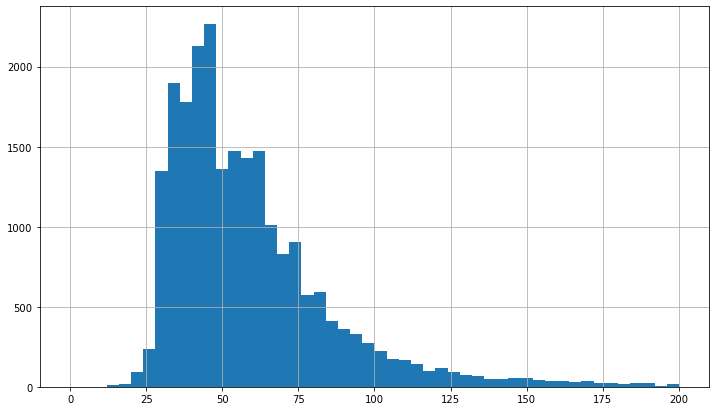

In [181]:
df['total_area'].hist(bins=50, figsize=(12, 7), range=(0,200))
plt.show()

Также была введена колонка `total_area_group`, которая сгруппировала квартиры в зависимости от их площади. 

In [182]:
colors = ['#ffa600', '#ff7c43', '#f95d6a', '#d45087', '#a05195', '#2f4b7c', '#003f5c']

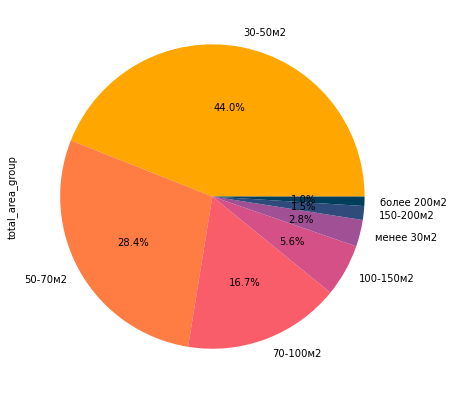

In [183]:
df['total_area_group'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(7, 7), colors=colors)
plt.show()

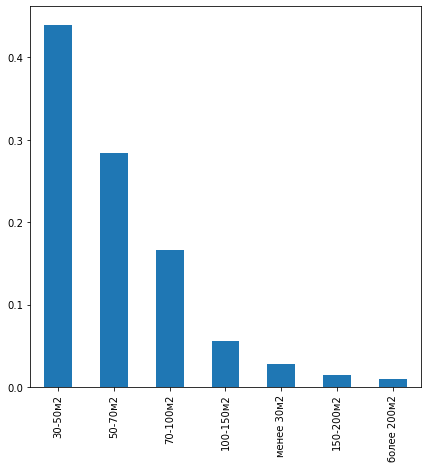

In [184]:
df['total_area_group'].value_counts(normalize=True).plot(kind='bar', figsize=(7, 7))
plt.show()

Можно заметить, что **большие (от 100м2) и маленькие (до 30м2) квартиры представлены меньше всего** - в сумме они составляют **менее 11%** всех объявлений, в то время, как **квартиры площадью 30-50м2 представлены в 44% всех объявлений**. 

**Квартиры 50-70м2 составляют чуть менее трети всех базы данных - 28,4% объявлений.**

**Квартиры 70-100м2 встречаются реже - в каждом шестом объявлении - 16,7%.**

**Цена**

Цена находится в колонке `last_price`. Так как там цена в рублях, а цены на квартиры зачастую измеряются миллионами рублей, можно создать колонку с ценой в миллионах для наглядности. 

In [185]:
df['last_price_kk'] = df['last_price'] / 1000000

In [186]:
df['last_price_kk'].describe().round(2)

count    22693.00
mean         6.69
std         11.10
min          0.43
25%          3.50
50%          4.70
75%          6.90
max        763.00
Name: last_price_kk, dtype: float64

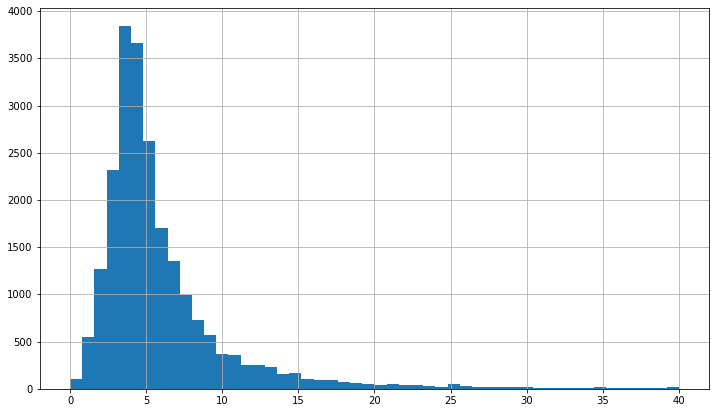

In [187]:
df['last_price_kk'].hist(bins=50, range = (0, 40), figsize = (12, 7))
plt.show()

Несмотря на наличие квартир стоимостью 500 миллионов и более, большиство выставленнных квартир стоят от 3 до 7 миллионов рублей. 

In [188]:
print ('Квартиры стоимостью от 3 до 7 млн. рублей составляют {:.1%} от всех объявлений.'
       .format(len(df.query('last_price_kk >= 3 and last_price_kk <= 7')) / len(df['last_price_kk']))
      )

Квартиры стоимостью от 3 до 7 млн. рублей составляют 60.7% от всех объявлений.


In [189]:
print ('Квартиры стоимостью до 10 млн. рублей составляют {:.1%} от всех объявлений.'
       .format(len(df.query('last_price_kk < 10')) / len(df['last_price_kk']))
      )

print ('Квартиры стоимостью до 15 млн. рублей составляют {:.1%} от всех объявлений.'
       .format(len(df.query('last_price_kk < 15')) / len(df['last_price_kk']))
      )

print ('Квартиры стоимостью до 20 млн. рублей составляют {:.1%} от всех объявлений.'
       .format(len(df.query('last_price_kk < 20')) / len(df['last_price_kk']))
      )

Квартиры стоимостью до 10 млн. рублей составляют 87.8% от всех объявлений.
Квартиры стоимостью до 15 млн. рублей составляют 94.5% от всех объявлений.
Квартиры стоимостью до 20 млн. рублей составляют 96.8% от всех объявлений.


**Число комнат**

Число комнат в квартире `rooms` также было бегло изучено при предобработке. 

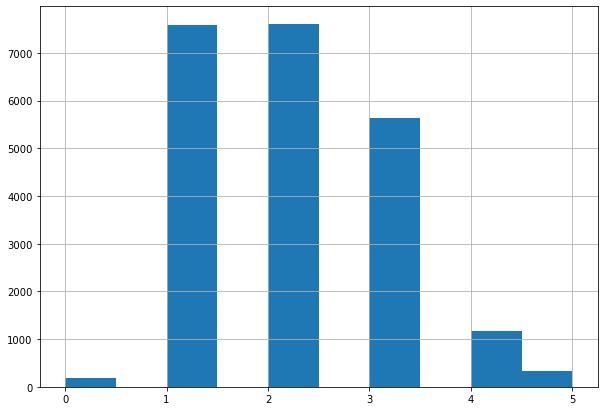

In [190]:
df['rooms'].hist(range=(0, 5), figsize=(10, 7))
plt.show()

In [191]:
df['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

In [192]:
df['rooms'].describe()

count    22693.000000
mean         2.086414
std          1.085243
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [193]:
def rooms_number(row):
    rooms = row['rooms']
    
    if rooms >= 5:
        return '5 и более'
    else:
        return rooms

In [194]:
df['rooms_number'] = df.apply(rooms_number, axis=1)

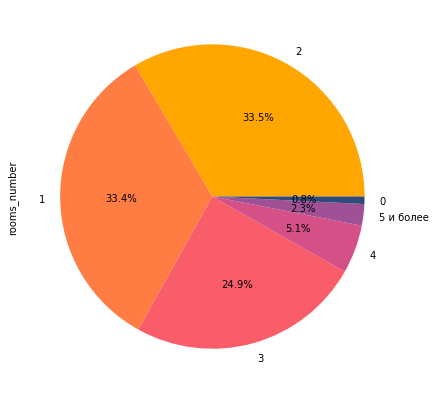

In [195]:
df['rooms_number'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(7, 7), colors=colors)
plt.show()

Две трети квартир имеет одну или две комнаты (по 33%), четверть квартир - трехкомнатные, каждая двадцатая квартира - четырехкомнатная. 

**Высота потолков**

С этой колонкой была проведена большая работа на предыдущем этапе - подозрительно маленькие и большие значения были перезаписаны. 

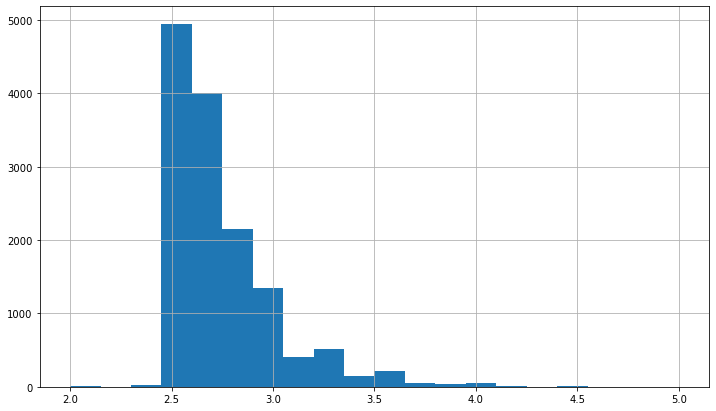

In [196]:
df['ceiling_height'].hist(bins=20, figsize=(12, 7), range=(2, 5))
plt.show()

In [197]:
df['ceiling_height'].describe()

count    13964.000000
mean         2.730623
std          0.293043
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

In [198]:
print(
    'В большинстве квартир - {:.1%} - потолок имеет высоту от 2.3 до 4 метров.'
    .format(len(df.query('ceiling_height >= 2.3 and ceiling_height <= 4')) / len(df['ceiling_height']))
    )
print (
    'Квартир с потолком 5 метров и более всего {} по всей базе.'
    .format(len(df.query('ceiling_height >= 5')))
    )

В большинстве квартир - 61.3% - потолок имеет высоту от 2.3 до 4 метров.
Квартир с потолком 5 метров и более всего 11 по всей базе.


### Время продажи квартир

In [199]:
df['days_exposition'].describe().round()

count    19631.0
mean       180.0
std        220.0
min          1.0
25%         44.0
50%         95.0
75%        230.0
max       1572.0
Name: days_exposition, dtype: float64

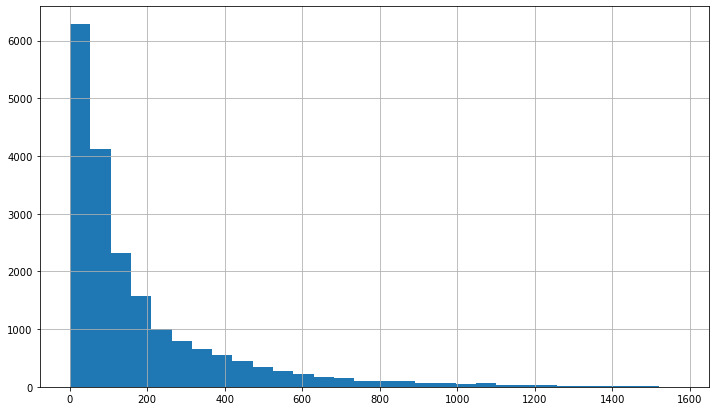

In [200]:
df['days_exposition'].hist(bins=30, figsize=(12, 7))
plt.show()

In [201]:
print (
    'Среднее время продажи - {:.4} дней после публикации.'
    .format(df['days_exposition'].mean())
    )
print (
    'Медиана - продажа за {:.4} дней после публикации.'
    .format(df['days_exposition'].median())
    )
print(
    'Больше года продавались {:.1%} квартир.'
    .format(len(df.query('days_exposition >= 365')) / len(df['days_exposition']))
    )
print(
    'Больше девяти месяцев - {:.1%} квартир.'
    .format(len(df.query('days_exposition >= 270')) / len(df['days_exposition']))
    )
print(
    'Больше половины квартир, а именно {:.1%}, были проданы в течение полугода после публикации объявлений о продаже.'
    .format(len(df.query('days_exposition <= 180')) / len(df['days_exposition']))
    )

print(
    'В течение трех месяцев было продано {:.1%} квартир.'
    .format(len(df.query('days_exposition <= 90')) / len(df['days_exposition']))
    )

print(
    'А в течение месяца после публикации продали {:.1%} квартир.'
    .format(len(df.query('days_exposition <= 30')) / len(df['days_exposition']))
    )

Среднее время продажи - 180.4 дней после публикации.
Медиана - продажа за 95.0 дней после публикации.
Больше года продавались 12.8% квартир.
Больше девяти месяцев - 18.6% квартир.
Больше половины квартир, а именно 59.2%, были проданы в течение полугода после публикации объявлений о продаже.
В течение трех месяцев было продано 41.1% квартир.
А в течение месяца после публикации продали 16.0% квартир.


Можно считать, что **продажа прошла очень быстро, если она была совершена в течение первого месяца** после публикации.

**Долгой продажей можно считать продажу от 9 месяцев.** 

### Работа с редкими и выбивающимися значениями была проведена в предыдущем этапе. 

In [202]:
df['total_area'].describe().round(2)

count    22693.00
mean        60.81
std         36.15
min         12.00
25%         40.00
50%         52.10
75%         70.00
max        900.00
Name: total_area, dtype: float64

<AxesSubplot:>

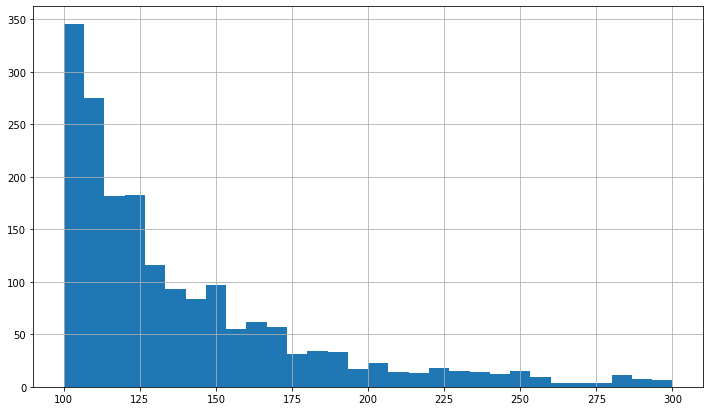

In [203]:
df['total_area'].hist(bins=30, range=(100, 300), figsize=(12, 7))

In [204]:
print (
    'Квартир площадью более 125м2 - {} в нашей базе.'
    .format(df.query('total_area > 125')['total_area'].count())
)
print (
    'Это {:.1%} от всех квартир.'
    .format(len(df.query('total_area > 125')) / len(df['total_area']))
)
print (
    'Но {:.1%} от площади всех квартир.'
    .format(df.query('total_area > 125')['total_area'].sum() / df['total_area'].sum())
)

print ()

print (
    'Квартир площадью более 150м2 - {} в нашей базе.'
    .format(df.query('total_area > 150')['total_area'].count())
)
print (
    'Это {:.1%} от всех квартир.'
    .format(len(df.query('total_area > 150')) / len(df['total_area']))
)
print (
    'Но {:.1%} от площади всех квартир.'
    .format(df.query('total_area > 150')['total_area'].sum() / df['total_area'].sum())
)

Квартир площадью более 125м2 - 936 в нашей базе.
Это 4.1% от всех квартир.
Но 12.5% от площади всех квартир.

Квартир площадью более 150м2 - 560 в нашей базе.
Это 2.5% от всех квартир.
Но 8.8% от площади всех квартир.


Мы можем легко отказаться от квартир площадью более 150м2 - удалив 560 квартир из базы, сумма площади которых 8.8% от всей площади квартир по базе. 

In [205]:
df.drop(df[df['total_area'] > 150].index, inplace=True)

In [206]:
df['total_area'].describe().round(2)

count    22133.00
mean        56.87
std         23.15
min         12.00
25%         40.00
50%         51.40
75%         68.00
max        150.00
Name: total_area, dtype: float64

Удалив 560 строк, значение `total_area` которых больше 150 м2, среднее значение площади сместилось с 60.8м2 до 56.87м2, среднее отклонение от 36.14 снизилось до 23.15. Медиана практически не изменилась, сместившись немного вниз: с 52.1 до 51.4м2.

### Факторы, влияющие на стоимость квартиры

Здесь необходимо изучить, как меняется стоимость квартиры в зависимости от ее площади, количества комнат, расстояния до центра города, этажа и времени публикации объявления. 

In [207]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_group,meter_price,weekday_exposition,month_exposition,year_exposition,floor_first_last,living_area_share,kitchen_area_share,last_price_kk,rooms_number
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,Санкт-Петербург,120370,3,March,2019,другой,0.472222,0.231481,13.000,3
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,поселок/пгт/коттеджный,82920,1,December,2018,первый,0.460396,0.272277,3.350,1
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,Санкт-Петербург,92785,3,August,2015,другой,0.612500,0.148214,5.196,2
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,Санкт-Петербург,100000,1,June,2018,другой,0.320000,0.410000,10.000,2
5,10,2890000,30.4,2018-09-10,1,NaN,12,14.4,5,False,...,поселок/пгт/коттеджный,95065,0,September,2018,другой,0.473684,0.299342,2.890,1


In [208]:
corr_test = df[['last_price', 'total_area', 'rooms', 'floor_first_last', 'cityCenters_nearest']]

In [209]:
corr_test.corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.700281,0.401010,-0.316124
total_area,0.700281,1.000000,0.786095,-0.223886
rooms,0.401010,0.786095,1.000000,-0.141656
cityCenters_nearest,-0.316124,-0.223886,-0.141656,1.000000


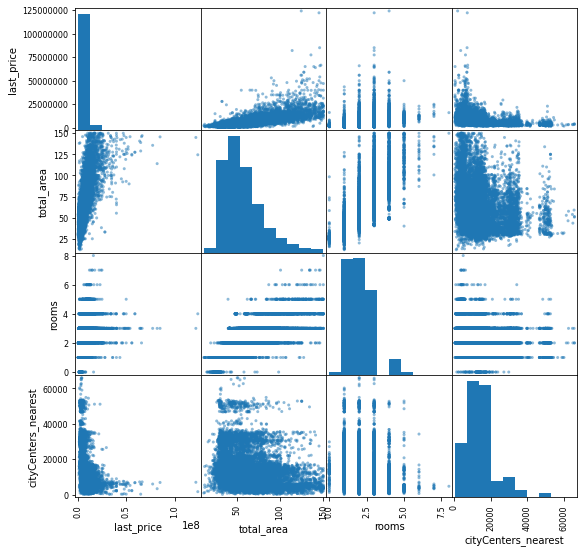

In [210]:
pd.plotting.scatter_matrix(corr_test, figsize=(9, 9))
plt.show()

Цена квартиры имеет сильную положительную корреляцию с площадью квартиры: чем больше площадь, тем выше цена. 
Корреляция цены и количества комнат слабее, но присутсвует: чем больше комнат, тем дороже квартира. 
Можно отметить слабую отрицательную корреляцию между удаленность от центра и ценой: чем выше цена, тем ближе центр города. 

In [211]:
df['last_price_kk'].describe()

count    22133.000000
mean         5.807468
std          4.587247
min          0.430000
25%          3.499000
50%          4.650000
75%          6.690000
max        124.000000
Name: last_price_kk, dtype: float64

In [212]:
print(
    'Квартиры на первом этаже в среднем стоят {:.2} млн. рублей.'
    .format(df.query('floor_first_last == "первый"')['last_price_kk'].mean())
    )
print (
    'Это {:0.1%} от стоимости средней квартиры.'
    .format(df.query('floor_first_last == "первый"')['last_price_kk'].mean() / df['last_price_kk'].mean()) 
    )
print (
    'Если рассматривать медианные значения, то квартиры на первом этаже стоят {:.2} млн. рублей.'
    .format(df.query('floor_first_last == "первый"')['last_price_kk'].median())
    )
print (
    'И это составляет {:0.1%} от стоимости медианной квартиры.'
    .format(df.query('floor_first_last == "первый"')['last_price_kk'].median() / df['last_price_kk'].median()) 
    )

Квартиры на первом этаже в среднем стоят 4.6 млн. рублей.
Это 79.2% от стоимости средней квартиры.
Если рассматривать медианные значения, то квартиры на первом этаже стоят 4.0 млн. рублей.
И это составляет 84.9% от стоимости медианной квартиры.


In [213]:
print(
    'Квартиры на последнем этаже в среднем стоят {:.2} млн. рублей.'
    .format(df.query('floor_first_last == "последний"')['last_price_kk'].mean())
    )
print (
    'Это {:0.1%} от стоимости средней квартиры.'
    .format(df.query('floor_first_last == "последний"')['last_price_kk'].mean() / df['last_price_kk'].mean()) 
    )
print (
    'Если рассматривать медианные значения, то квартиры на последнем этаже стоят {:.2} млн. рублей.'
    .format(df.query('floor_first_last == "последний"')['last_price_kk'].median())
    )
print (
    'И это составляет {:0.1%} от стоимости медианной квартиры.'
    .format(df.query('floor_first_last == "последний"')['last_price_kk'].median() / df['last_price_kk'].median()) 
    )

Квартиры на последнем этаже в среднем стоят 5.4 млн. рублей.
Это 93.7% от стоимости средней квартиры.
Если рассматривать медианные значения, то квартиры на последнем этаже стоят 4.3 млн. рублей.
И это составляет 92.5% от стоимости медианной квартиры.


In [214]:
print ('Что же касается квартир, расположенных не на первом или последнем этажах:')

print(
    'Такие квартиры в среднем стоят {:.2} млн. рублей.'
    .format(df.query('floor_first_last == "другой"')['last_price_kk'].mean())
    )
print (
    'Это {:0.1%} от стоимости средней квартиры.'
    .format(df.query('floor_first_last == "другой"')['last_price_kk'].mean() / df['last_price_kk'].mean()) 
    )
print (
    'Если рассматривать медианные значения, такие квартиры стоят {:.2} млн. рублей.'
    .format(df.query('floor_first_last == "другой"')['last_price_kk'].median())
    )
print (
    'И это составляет {:0.1%} от стоимости медианной квартиры.'
    .format(df.query('floor_first_last == "другой"')['last_price_kk'].median() / df['last_price_kk'].median()) 
    )

Что же касается квартир, расположенных не на первом или последнем этажах:
Такие квартиры в среднем стоят 6.1 млн. рублей.
Это 104.7% от стоимости средней квартиры.
Если рассматривать медианные значения, такие квартиры стоят 4.8 млн. рублей.
И это составляет 104.3% от стоимости медианной квартиры.


In [215]:
df.query('floor_first_last == "последний"').sort_values(by='last_price', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_group,meter_price,weekday_exposition,month_exposition,year_exposition,floor_first_last,living_area_share,kitchen_area_share,last_price_kk,rooms_number
11430,20,85000000,145.7,2018-08-16,3,3.36,5,87.23,5,False,...,Санкт-Петербург,583390,3,August,2018,последний,0.598696,0.139396,85.000000,3
23574,14,64990000,139.0,2015-11-24,3,3.00,8,62.60,8,False,...,Санкт-Петербург,467553,1,November,2015,последний,0.450360,0.115108,64.990000,3
18770,20,49000000,125.0,2019-01-29,3,2.91,6,73.90,6,False,...,Санкт-Петербург,392000,1,January,2019,последний,0.591200,0.077600,49.000000,3
19229,17,47700000,125.1,2016-06-21,4,NaN,8,65.93,8,False,...,Санкт-Петербург,381294,1,June,2016,последний,0.527018,0.092006,47.700000,4
11492,1,46424072,92.4,2014-12-09,2,NaN,6,54.80,6,True,...,Санкт-Петербург,502425,1,December,2014,последний,0.593074,0.216450,46.424072,2
2905,19,39900000,125.0,2017-12-13,4,3.30,14,77.00,14,False,...,Санкт-Петербург,319200,2,December,2017,последний,0.616000,0.128000,39.900000,4
6336,20,39000000,118.0,2017-08-10,4,NaN,4,89.20,4,False,...,Санкт-Петербург,330508,3,August,2017,последний,0.755932,0.112712,39.000000,4
7578,17,38000000,143.0,2017-11-02,3,5.50,5,83.00,5,False,...,Санкт-Петербург,265734,3,November,2017,последний,0.580420,0.202797,38.000000,3
3527,17,37272000,100.6,2016-06-26,3,NaN,8,57.50,8,False,...,Санкт-Петербург,370497,6,June,2016,последний,0.571571,0.144831,37.272000,3
22107,20,34000000,120.0,2017-12-15,3,NaN,15,70.00,15,False,...,Санкт-Петербург,283333,4,December,2017,последний,0.583333,0.100000,34.000000,3


In [216]:
df.sort_values(by='last_price', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_group,meter_price,weekday_exposition,month_exposition,year_exposition,floor_first_last,living_area_share,kitchen_area_share,last_price_kk,rooms_number
4996,20,124000000,124.5,2017-10-12,4,3.00,4,67.20,2,False,...,Санкт-Петербург,995983,3,October,2017,другой,0.539759,0.160643,124.000,4
16647,15,122000000,145.0,2017-04-25,3,3.30,6,36.00,2,False,...,Санкт-Петербург,841379,1,April,2017,другой,0.248276,0.496552,122.000,3
11430,20,85000000,145.7,2018-08-16,3,3.36,5,87.23,5,False,...,Санкт-Петербург,583390,3,August,2018,последний,0.598696,0.139396,85.000,3
6462,2,82000000,114.0,2015-12-17,3,NaN,5,78.50,4,False,...,Санкт-Петербург,719298,3,December,2015,другой,0.688596,0.175439,82.000,3
15726,7,77349000,135.7,2017-12-16,3,NaN,7,62.60,5,False,...,Санкт-Петербург,570000,5,December,2017,другой,0.461312,0.114959,77.349,3
11912,20,66500000,147.2,2016-05-13,3,3.00,6,91.00,3,False,...,Санкт-Петербург,451766,4,May,2016,другой,0.618207,0.108696,66.500,3
16797,9,65850000,146.0,2017-07-14,2,NaN,9,40.00,3,False,...,Санкт-Петербург,451027,4,July,2017,другой,0.273973,0.636986,65.850,2
13919,12,65000000,129.0,2017-09-25,3,NaN,6,72.00,5,False,...,Санкт-Петербург,503875,0,September,2017,другой,0.558140,0.147287,65.000,3
23574,14,64990000,139.0,2015-11-24,3,3.00,8,62.60,8,False,...,Санкт-Петербург,467553,1,November,2015,последний,0.450360,0.115108,64.990,3
19151,9,63900000,140.8,2017-07-13,3,3.30,6,74.30,4,False,...,Санкт-Петербург,453835,3,July,2017,другой,0.527699,0.142045,63.900,3


Таким образом, квартиры, расположенные на первом этаже здания, в стоят дешевле средних квартир. В этом нет ничего удивительного: традиционно квартиры на первом этаже пользуются меньшей популярностью. Люди привыкли считать, что такие квартиры менее безопасны (могут залезть и ограбить), здесь выше уровень шума, ближе подвалы (а, значит, и комары с тараканами), да еще и в окна прохожие могут заглянуть.

Квартиры на последнем этаже стоят в среднем и по медиане дороже квартир на первом этаже.
Если сравнивать квартиры на последнем этаже с квартирами, расположенными со второго до предпоследного этажах, можно заметить, что средняя и медианная стоимости квартиры на последнем этаже несколько ниже. Возможно, на это оказывает влияние отсуствие лифта во многих типовых постройках. 

In [217]:
df.pivot_table(index='year_exposition', values='last_price_kk', aggfunc='median').round(2)

,last_price_kk
year_exposition,
2014,7.49
2015,5.24
2016,4.55
2017,4.50
2018,4.60
2019,5.10


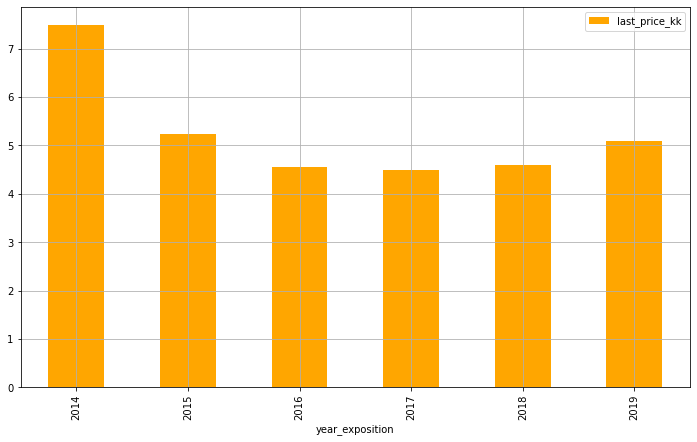

In [218]:
df.pivot_table(index='year_exposition', values='last_price_kk', aggfunc='median').plot(kind='bar', figsize=(12, 7), grid=True, color=colors)
plt.show()

In [219]:
len(df.query('year_exposition == 2014'))

118

In [220]:
df.pivot_table(index='year_exposition', values='last_price_kk', aggfunc=['count', 'median', freq]).round(2)

,count,median,freq
,last_price_kk,last_price_kk,last_price_kk
year_exposition,,,
2014,118,7.49,0.5%
2015,1077,5.24,4.9%
2016,2571,4.55,11.6%
2017,7580,4.50,34.2%
2018,8042,4.60,36.3%
2019,2745,5.10,12.4%


Самые дорогие по медиане квартиры были выставлены в 2014 году - медианная квартира стоила 7.49 млн. Однако, это не означает, что рынок недвижимости в 2014 году так отличался от последующих годов. Данные искажены, так как объявлений на 2014 год всего 118 на всю базу данных: мы не можем им верить. Данные 2015 года тоже не факт, что отражают реальность - их только 4.9% по всей базе. 

А вот начиная с 2016 года на данные можно обратить внимание. С 2016 по 2018 медианная квартира стабильно стоила около 4.5-4.6 млн. И только в 2019 подорожала до 5.1 млн.

In [221]:
df.groupby('month_exposition')['last_price_kk'].median().round(2).sort_values(ascending=False)

month_exposition
April        4.80
December     4.70
March        4.70
November     4.70
September    4.70
February     4.65
August       4.60
January      4.60
July         4.60
October      4.60
May          4.50
June         4.49
Name: last_price_kk, dtype: float64

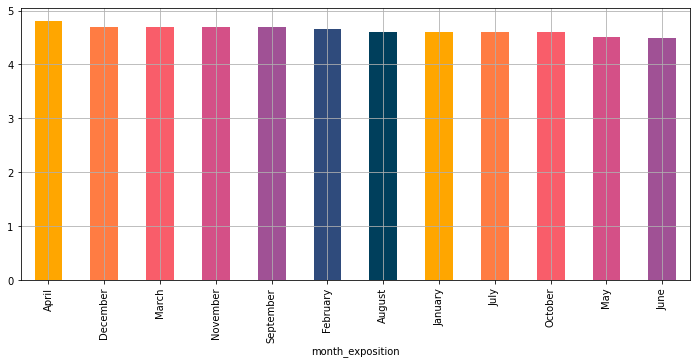

In [222]:
df.groupby('month_exposition')['last_price_kk'].median().round(2).sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), grid=True, color=colors)
plt.show()

Медианная стоимость квартир немного меняется по месяцам: самые дорогие квартиры выставлены в апреле (4.8 млн.), а квартиры с самой низкой медианной стоимостью - в июне (4.49 млн.). Тем не менее, эту разницу вряд ли можно назвать определяющей, т.к. между самой дорогой и самой недорогой медианной квартирой по месяцам разница в 310 тысяц рублей - скорее, просто так получилось и никакой зависимости здесь нет.

In [223]:
df.groupby('weekday_exposition')['last_price_kk'].median().round(2).sort_values(ascending=False)

weekday_exposition
1    4.75
2    4.70
0    4.65
3    4.63
4    4.60
5    4.60
6    4.56
Name: last_price_kk, dtype: float64

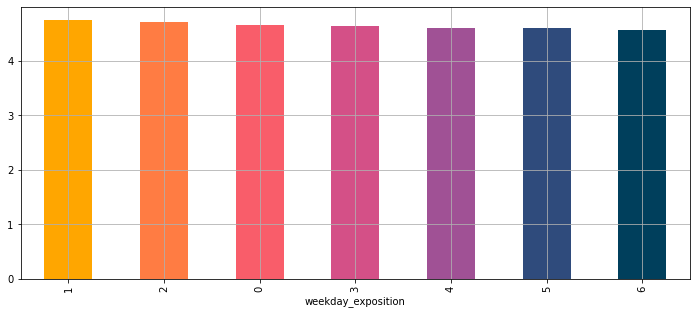

In [224]:
df.groupby('weekday_exposition')['last_price_kk'].median().round(2).sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), grid=True, color=colors)
plt.show()

Похожая ситуация прослеживается в днях недели, в которые было выставлено объявление о продаже: между самым "дорогим" медианным днем (4.75 млн.) - понедельников - и самым "недорогим" (4.56 млн.) - субботой - не очень большая разница. Скорее всего, о взаимосвязи здесь речь не идет.

**Таким образом, стоимость квартиры напрямую зависит от площади и близости к центру: чем больше квартира (и, соотвественно, в ней больше комнат) и чем ближе она к центру, тем стоимость выше. Исключением являются квартиры в поселке Лисий нос и Зеленогорске - несмотря на некоторую удаленность от центра, квартиры в этих населенных пунктах стоят дороже чем в Петербурге, так как они расположены на берегу Финского залива и в 30-60 минутах езды до центра города.**

**Квартиры на первом этаже традиционно дешевле (медианная квартира на первом стоит 4.0 млн. рублей, а медианная квартира по всей базе данных - 4.65 млн.). Это объясняется шумом, желаниями жить приватно и не бояться грабителей.**

**Стоимость квартир с 2016 года по 2018 держалась на примерно одинаковом медианном уровне - 4.5 - 4.6 млн. рублей, и в 2019 году повысилась до 5.1 млн.**

### 10 населенных пунктов с наибольшим количеством объявлений

В этом задании необходимо выделить 10 населенных пунктов, а также рассчитать цену квадратного метра в этих населенных пунктах. Далее необходимо определить населенные пункты с самой высокой и низкой стоимостью жилья. 

In [225]:
df.groupby('locality_name')['meter_price'].agg(['count', freq, 'mean']).sort_values(by='count', ascending=False).head(10).round(2)

,count,freq,mean
locality_name,,,
Санкт-Петербург,15218,68.8%,112327.06
посёлок Мурино,522,2.4%,85751.73
посёлок Шушары,440,2.0%,78676.90
Всеволожск,397,1.8%,68702.65
Пушкин,359,1.6%,102866.08
Колпино,337,1.5%,75332.87
посёлок Парголово,326,1.5%,90331.84
Гатчина,307,1.4%,68745.69
Выборг,235,1.1%,58075.47


Разумеется, лидирует Санкт-Петербург - 68.8% от всех объявлений. Там и самая высокая стоимость квадратного метра жилья из этих десятки. На втором месте по количеству объявлений посёлок Мурино (2.4%), а на третьем - посёлок Шушары (2.0%). 

Тем не менее, если рассматривать стоимость квадратного метра в этих населенных пунктах, на втором месте будет город Пушкин, на третьем - посёлок Парголово, а замыкает десятку город Выборг. 

In [226]:
print ('Населенные пункты с самой высокой стоимостью жилья:')
display (df.groupby('locality_name')['meter_price'].agg('mean').sort_values(ascending=False).head(10).round(2))

print ('И с самой низкой:')
display (df.groupby('locality_name')['meter_price'].agg('mean').sort_values(ascending=True).head(10).round(2))

Населенные пункты с самой высокой стоимостью жилья:


locality_name
посёлок Лисий Нос    121615.50
Зеленогорск          117810.30
Санкт-Петербург      112327.06
Пушкин               102866.08
Сестрорецк           102107.36
Кудрово              100252.60
посёлок Левашово      96997.00
Мурино                92722.26
посёлок Парголово     90331.84
посёлок Стрельна      89122.50
Name: meter_price, dtype: float64

И с самой низкой:


locality_name
посёлок станции Свирь                 11481.00
поселок Совхозный                     12628.50
поселок Тёсово-4                      12931.00
поселок Житково                       14956.00
поселок станции Лужайка               15000.00
поселок Почап                         16037.00
поселок городского типа Ефимовский    16049.67
посёлок Шугозеро                      16608.00
поселок Серебрянский                  16756.00
поселок Володарское                   16927.00
Name: meter_price, dtype: float64

По средней стоимость 1м2 жилья Петербург обгоняют посёлок Лисий Нос и город Зеленогорск - оба на побережье Финского залива относительно недалеко от города: 35 и 60 минут на машине соответственно. 

Что же касается самой низкой стоимости 1м2 жилья, здесь лидируют посёлки, расположенные за 100+ км от Петербурга и не имеющие выхода к заливу или озёрам. 

### Квартиры в центре Петербурга: выделение области

In [227]:
df['center_km'] = df['cityCenters_nearest'] / 1000

In [228]:
df['center_km'] = df['center_km'].round(0)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22133 entries, 0 to 23698
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22133 non-null  int64         
 1   last_price            22133 non-null  int64         
 2   total_area            22133 non-null  float64       
 3   first_day_exposition  22133 non-null  datetime64[ns]
 4   rooms                 22133 non-null  int64         
 5   ceiling_height        13587 non-null  float64       
 6   floors_total          22133 non-null  int64         
 7   living_area           22133 non-null  float64       
 8   floor                 22133 non-null  int64         
 9   is_apartment          22133 non-null  bool          
 10  studio                22133 non-null  bool          
 11  open_plan             22133 non-null  bool          
 12  kitchen_area          22133 non-null  float64       
 13  balcony         

<AxesSubplot:xlabel='center_km'>

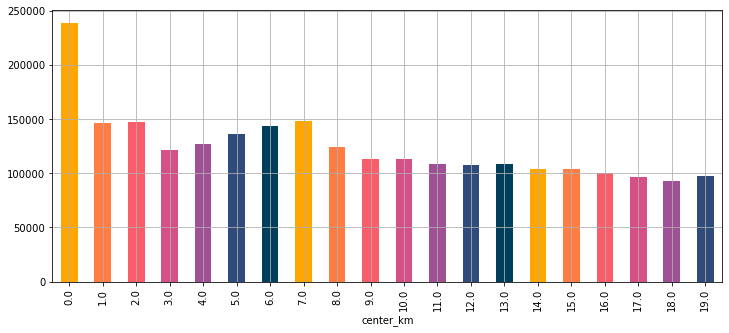

In [230]:
df.groupby('center_km')['meter_price'].mean().head(20).plot(kind='bar', figsize=(12, 5), grid=True, color=colors)

In [231]:
df.groupby('center_km')['meter_price'].mean().head(10).round(2)

center_km
0.0    239005.89
1.0    146802.37
2.0    147203.08
3.0    121418.39
4.0    127017.93
5.0    135750.30
6.0    143204.97
7.0    147755.57
8.0    123763.28
9.0    112964.50
Name: meter_price, dtype: float64

Можно заметить, что средняя цена 1м2 падает со 238 тыс. до 121 тыс. в радиусе 3 км от центра города. Можно предположить, что на уровне радиуса 3 км "заканчивается" Центральный район. Это подтверждают карты. 
Далее виден всплеск в радиусе 4-7 км от центра: вероятно, здесь оказывают влияние квартиры, расположенные в Петроградском, Василеостровском и Адмиралтейском районах.

### Квартиры в центре Петербурга: отличия от общих выводов по городу

Здесь необходимо проанализировать площадь, цену, число комнат и высоту полотков в центре Петербурга и сравнить эти данные со средними значениями по городу. Далее нужно выделить, что влияет на стоимость квартиры. 

In [232]:
df.query('center_km <= 3')[['last_price_kk', 'total_area', 'rooms', 'ceiling_height']].agg(['mean', 'median', 'min', 'max']).round(2)

,last_price_kk,total_area,rooms,ceiling_height
mean,11.18,81.15,2.75,3.19
median,9.00,78.60,3.00,3.15
min,2.10,12.00,0.00,2.50
max,124.00,150.00,7.00,5.80


Квартиры в радиусе до 3 км от центра Петербурга имеют в среднем 3 комнаты и высокие потолки - около 3.1 м. По стоимости можно наблюдать большой разброс: медианная квартира стоит 9 млн., а средняя - 11.18 млн. Это означает, что в выборке есть как очень большие (150м2), так и маленькие (12м2) квартиры. 

In [233]:
df.query('locality_name == "Санкт-Петербург"')[['last_price_kk', 'total_area', 'rooms', 'ceiling_height']].agg(['mean', 'median', 'min', 'max']).round(2)

,last_price_kk,total_area,rooms,ceiling_height
mean,6.86,59.49,2.07,2.75
median,5.40,54.00,2.00,2.70
min,1.19,12.00,0.00,2.00
max,124.00,150.00,8.00,8.30


Если смотреть на Санкт-Петербург в целом, он сильно отличается по всем параметрам от квартир в самом центре города: средняя стоимость значительно ниже (6.86 млн. против 11.18 млн.), комнат в среднем меньше (2 против 3), площадь тоже меньше (81.15м2 в среднем в центре против 59.49 в среднем по городу), потолки ниже (3 м против 2.7 м).

In [234]:
df.query('center_km <= 3')[['last_price_kk', 'meter_price', 'total_area', 'rooms', 'ceiling_height', 'cityCenters_nearest']].corr().round(2)

,last_price_kk,meter_price,total_area,rooms,ceiling_height,cityCenters_nearest
last_price_kk,1.00,0.81,0.45,0.19,0.13,-0.16
meter_price,0.81,1.00,-0.03,-0.17,0.12,-0.17
total_area,0.45,-0.03,1.00,0.72,0.11,-0.06
rooms,0.19,-0.17,0.72,1.00,-0.05,-0.02
ceiling_height,0.13,0.12,0.11,-0.05,1.00,-0.11
cityCenters_nearest,-0.16,-0.17,-0.06,-0.02,-0.11,1.00


In [235]:
df.query('locality_name == "Санкт-Петербург"')[['last_price_kk', 'meter_price', 'total_area', 'rooms', 'ceiling_height', 'cityCenters_nearest']].corr().round(2)

,last_price_kk,meter_price,total_area,rooms,ceiling_height,cityCenters_nearest
last_price_kk,1.00,0.76,0.72,0.42,0.42,-0.37
meter_price,0.76,1.00,0.18,-0.08,0.30,-0.33
total_area,0.72,0.18,1.00,0.78,0.44,-0.33
rooms,0.42,-0.08,0.78,1.00,0.21,-0.24
ceiling_height,0.42,0.30,0.44,0.21,1.00,-0.52
cityCenters_nearest,-0.37,-0.33,-0.33,-0.24,-0.52,1.00


Можно заметить, что в центре города удаленность от самой центральной точки на цену практически не влияет, а в Петербурге в целом наблюдается небольшая отрицательная корреляция: чем ближе к центру, тем дороже квартира (и квадратный метр).
Стоит отметить очевидную зависимость стоимости квартиры от ее площади: чем больше квартира, тем она дороже. Эта зависимость немного сильнее для Петербурга в целом, чем для самого центрального района. То же самое прослеживается и для количества комнат.
Высота полотков немного связана с ценой для всего города: присуствует небольшая положительная корреляция. А вот для центра такая связь не обнаруживается.

In [236]:
df.query('center_km <= 3').pivot_table(index='year_exposition', values='last_price_kk', aggfunc='median').round(2)

,last_price_kk
year_exposition,
2014,24.00
2015,9.72
2016,9.35
2017,8.40
2018,9.20
2019,10.00


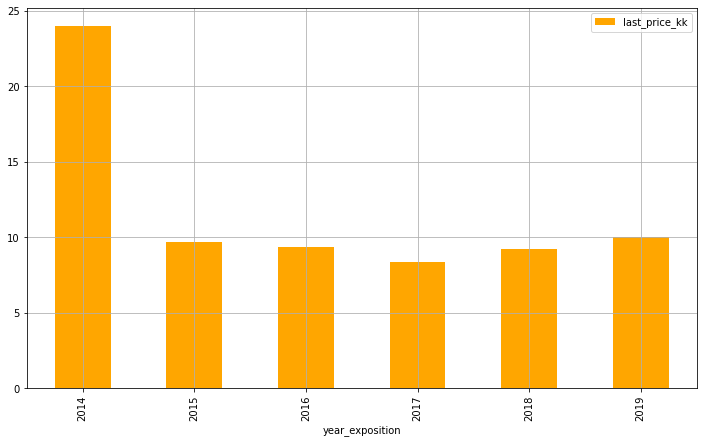

In [237]:
df.query('center_km <= 3').pivot_table(index='year_exposition', values='last_price_kk', aggfunc='median').plot(kind='bar', figsize=(12, 7), grid=True, color=colors)
plt.show()

In [238]:
df.query('locality_name == "Санкт-Петербург"').pivot_table(index='year_exposition', values='last_price_kk', aggfunc='median').round(2)

,last_price_kk
year_exposition,
2014,9.20
2015,5.93
2016,5.30
2017,5.20
2018,5.40
2019,5.80


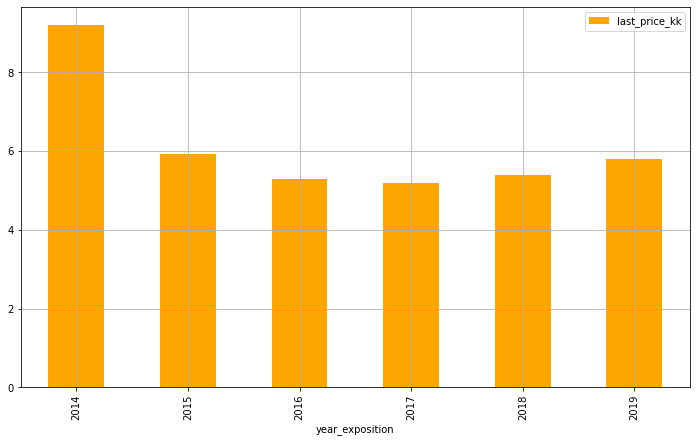

In [239]:
df.query('locality_name == "Санкт-Петербург"').pivot_table(index='year_exposition', values='last_price_kk', aggfunc='median').plot(kind='bar', figsize=(12, 7), grid=True, color=colors)
plt.show()

Если рассматривать год публикации объявлений, но исключить из анализы 2014 и 2015 годы (когда количество объявлений было ничтожно мало по сравнению с последующими годами), можно заметить, что стоимость медианной квартиры в Санкт-Петербурге в целом и медианной квартиры в центре города в пропорциональном соотношении менялись приблизительно одинаково. Так в 2017 году стоимость медианной квартиры несколько снизилась - причем, это более заметно по квартирам в центре. Так или иначе, квартиры в по городу с 2016 по 2018 годы стоили в пределах 5.4 млн., а в центре - от 8.4 до 9.35 млн. В 2019 году стоимость повысилась: до 5.8 млн. по городу и до 10 млн. в центре.

**Для квартир, расположенных в центре города (в радиусе 3 км от центральной точки) характерна, что очевидно, более высокая цена, чем в среднем по городу. Также в центральных квартирах в среднем больше комнат (3 против 2), соотвественно, больше общая площадь (81.15м2 в среднем в центре против 59.49м2 в среднем по городу) и чуть более высокие потолки (3.15 м против 2.7 м).**

**Для квартир, расположенных в центре, в отличие от квартир по городу в целом, удаленность от центральной точки не вляет на цену; в то время как общегородская интуитивно понятная тенденция в том, что с приближением к центру возрастает и цена недвижимости.**

**С 2016 по 2019 год стоимость квартир в центре претерпевала примерно не же изменения, что и стоимость квартир по городу в целом. Квартиры в центре стоят стабильно дороже.**

## Общий вывод

In [240]:
print(
'В оригинальной базе данных было', entries_original, 'строк.'
)
print(
'По итогам предобработки мы избавились от', (entries_original-len(df)), 'строк.'
)
print(
'Так, база данных, над которой проводился исследовательский анализ данных составила {:.1%} от оригинальной базы данных.'
.format (len(df)/entries_original)    
)

print()

print(
'В оригинальной базе данных было', nas_original, 'пропущенных значений.')
print(
'В ходе предобработки мы заполнили/удалили большую часть из них: сейчас в базе {} пропущенных значений.'
.format(df.isnull().sum().sum())
)

В оригинальной базе данных было 23699 строк.
По итогам предобработки мы избавились от 1566 строк.
Так, база данных, над которой проводился исследовательский анализ данных составила 93.4% от оригинальной базы данных.

В оригинальной базе данных было 101441 пропущенных значений.
В ходе предобработки мы заполнили/удалили большую часть из них: сейчас в базе 20491 пропущенных значений.


В этом проекте были изучены квартиры в Санкт-Петербурге и ЛО.

В ходе первого этапа была проведена работа с пропусками и выбивающимися значениями.

Далее были изменены типы данных в соотвествии с содержащейся в колонках информацией: данные типа _float_ в большинстве случаев были приведены к целочисленным значениям _int_; колонка, содержащая дату и время публикации объявлений приведена к формату _datetime_.

После этого были добавлены новые колонки, обозначающие цену квадратного метра, день недели, месяц и год публикации объявления, соотношение жилой и общей площади, а также отношение площади кухни к общей.

После этого были проанализированы площадь, цена, число комнат и высота потолков в квартирах. Большинство квартир (более 70% всех объявлений) имеет площадь от 30 до 70 м2. Квартиры больше или меньше этого диапазона в базе данных распространены значительно реже. Медианная квартира имеет 2 комнаты с потолками около 2.7 м и стоит около 4.65 млн. рублей.

Обычно (в 59% случаев) квартира продается в течение полугода после публикации. Медианная квартира продается за 95 дней. Было принято считать быстро продажей продажу в течение месяца, а долгой - продажу, которая затянулась более, чем на 9 месяцев.

На стоимость квартиры влияют достаточно очевидные факторы: площадь (и, соотвественно, количество комнат), этаж (квартиры на первом этаже стоят дешевле), приближенность к центру города. Можно предположить, что день и месяц размещения объявления навряд ли оказывают влияние на стоимость. А между годом размещения и стоимостью квартиры взаимосвязь, вероятно, присутствует: если с 2016 по 2018 год квартиры в среднем стоили примерно одинаково (4.5-4.6 млн.), то в 2019 году они подорожали до 5.1 млн.

Неудивительно, что наибольшее количество объявлений опубликовано для Санкт-Петербурга - 68.8% от всех объявлений. А вот по цене за квадратный метр жилья Петербург на третьем месте (112.3 тыс.): его обогнали поселок Лисий Нос (121.6 тыс.) и город Зеленогорск (117.8 тыс.). Эти населенные пункты находятся в 30-60 минутах езды до центра города и располагаются на берегу Финского залива.

В рамках проекта также стояла задача определить центр города. Высказывается предположение, что центр города соотвествует Центральному району и располагается в радиусе 3 км. от центральной точки Петербурга.

Если изучать квартиры, расположенные внутри центральной зоны, то можно заметить, что их стоимость значительно выше стоимости квартир по Санкт-Петербургу в целом: медианная квартира в центре стоит 9 млн., а по городу - 5.4 млн. В объявлениях о продаже квартир в центре прослеживается тенденция к большему, чем по медиане по городу, количеству комнат (3 против 2) и общей площади (81.15м2 в среднем против 59.49м2) и более высоких потолках (3м против 2.7м).